In [127]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 

In [128]:
# Deterministic model
def model_non_stochastic(t, x, P):
    IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3 = P
    c0 = 2
    c1 = 0.185

    Ca, h = x
    CaER = (c0 - Ca) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca / (Ca + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)

    alphah = hinf / tauh
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h) - betah * h
    dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)

    return np.array([dCa, dh])

# Stochastic model
def model_stochastic(t, x, P, dt):
    IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3 = P
    c0 = 2
    c1 = 0.185

    Ca, h = x
    CaER = (c0 - Ca) / c1
    pinf = IP3 / (IP3 + d1)
    ninf = Ca / (Ca + d5)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)

    alphah = hinf / tauh
    betah = (1 - hinf) / tauh
    dh = alphah * (1 - h) - betah * h
    dCa = c1 * v1 * pinf**3 * ninf**3 * h**3 * (CaER - Ca) + c1 * v2 * (CaER - Ca) - v3 * Ca**2 / (Ca**2 + k3**2)

    # Stochastic noise
    Nd = 2
    gamma1, gamma2 = np.random.rand(2)
    gh = np.sqrt(-2 * (alphah * (1 - h) + betah * h) * np.log(gamma1) / Nd) * np.sin(2 * np.pi * gamma2)
    dh += gh * np.sqrt(dt)

    return np.array([dCa, dh])

# **Trainable Fourier Coefficients**

In [144]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

## **Stochastic Data - 1**

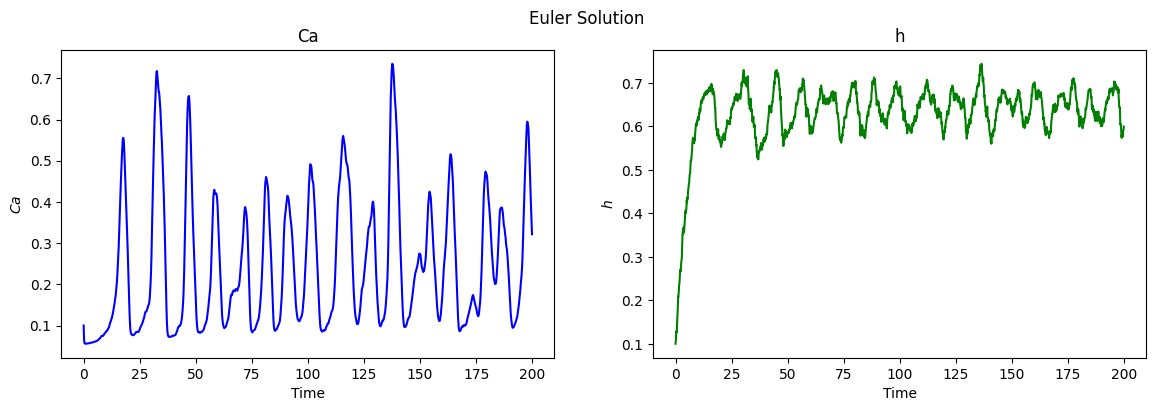

In [145]:
np.random.seed(42)
P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([0.1, 0.1])
y = np.zeros((2, num_steps))
y[:, 0] = y02

for n in range(num_steps - 1):
    f = model_stochastic(t[n], y[:, n], P, dt)
    y[:, n + 1] = y[:, n] + dt * f

Ca_non_stoch, h_non_stoch = y

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_non_stoch, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_non_stoch, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Epoch = 0 | Loss = 0.009160399436950684 | Physics_loss = 0.6610284447669983 | Initial_loss = 0.0 | Data_loss = 0.23182865977287292


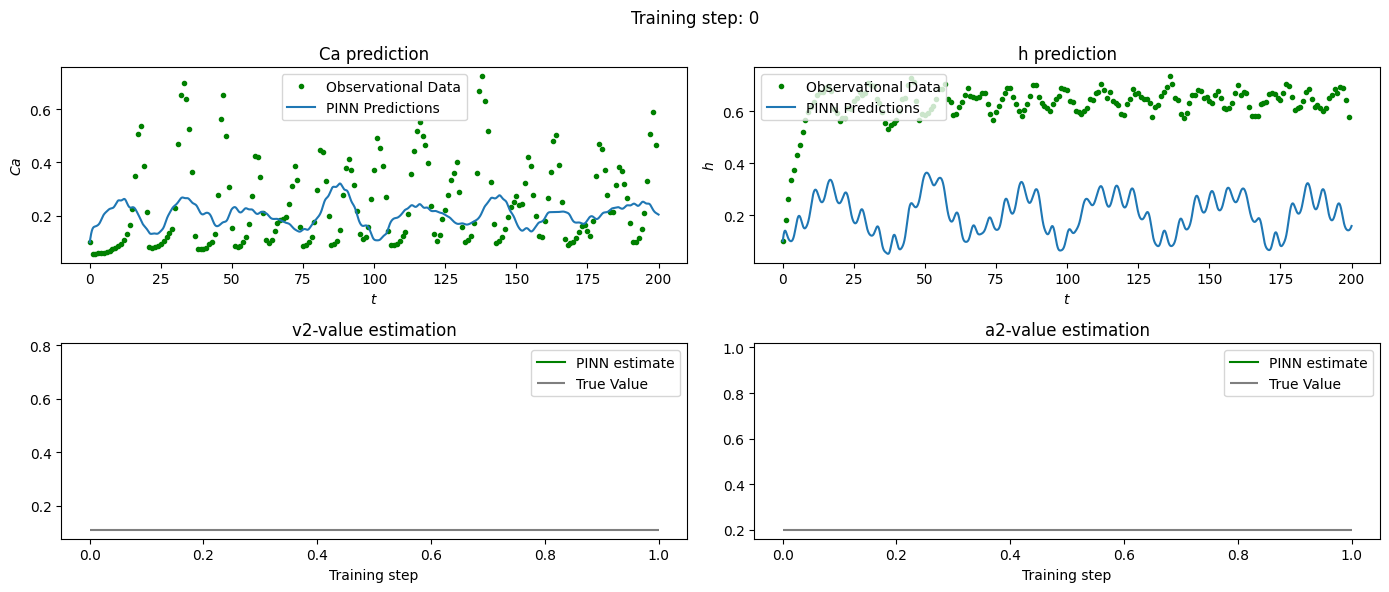

Epoch = 1000 | Loss = 0.00013487388787325472 | Physics_loss = 0.004093348979949951 | Initial_loss = 0.0 | Data_loss = 0.008540036156773567


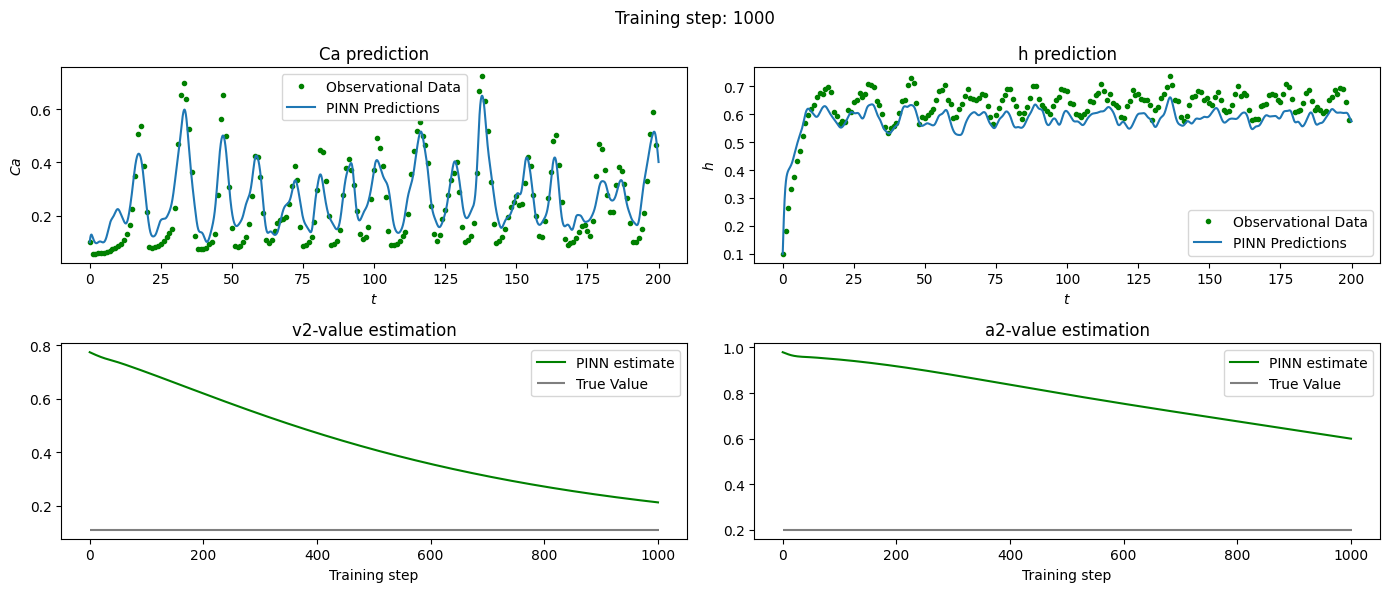

Epoch = 2000 | Loss = 1.2781818440998904e-05 | Physics_loss = 0.0005924436263740063 | Initial_loss = 0.0 | Data_loss = 0.0006233983440324664


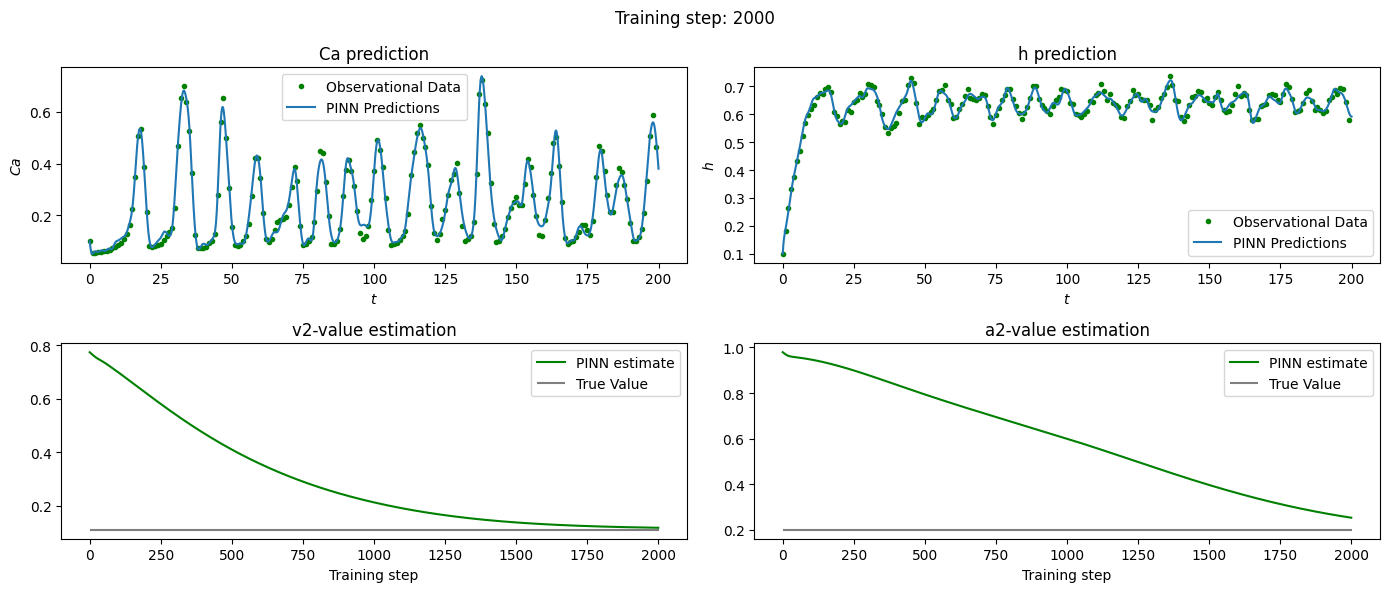

Epoch = 3000 | Loss = 6.379864316841122e-06 | Physics_loss = 0.00032625565654598176 | Initial_loss = 0.0 | Data_loss = 0.00028339162236079574


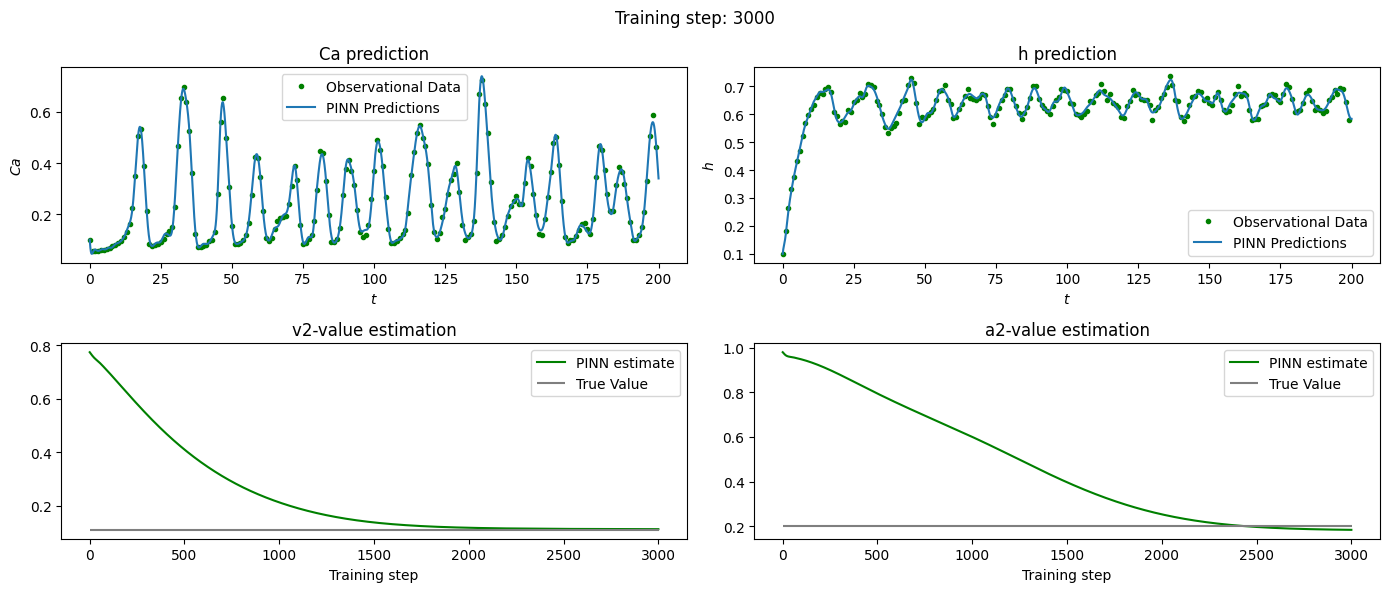

Epoch = 4000 | Loss = 5.172996679903008e-06 | Physics_loss = 0.00028497431776486337 | Initial_loss = 0.0 | Data_loss = 0.0002112048678100109


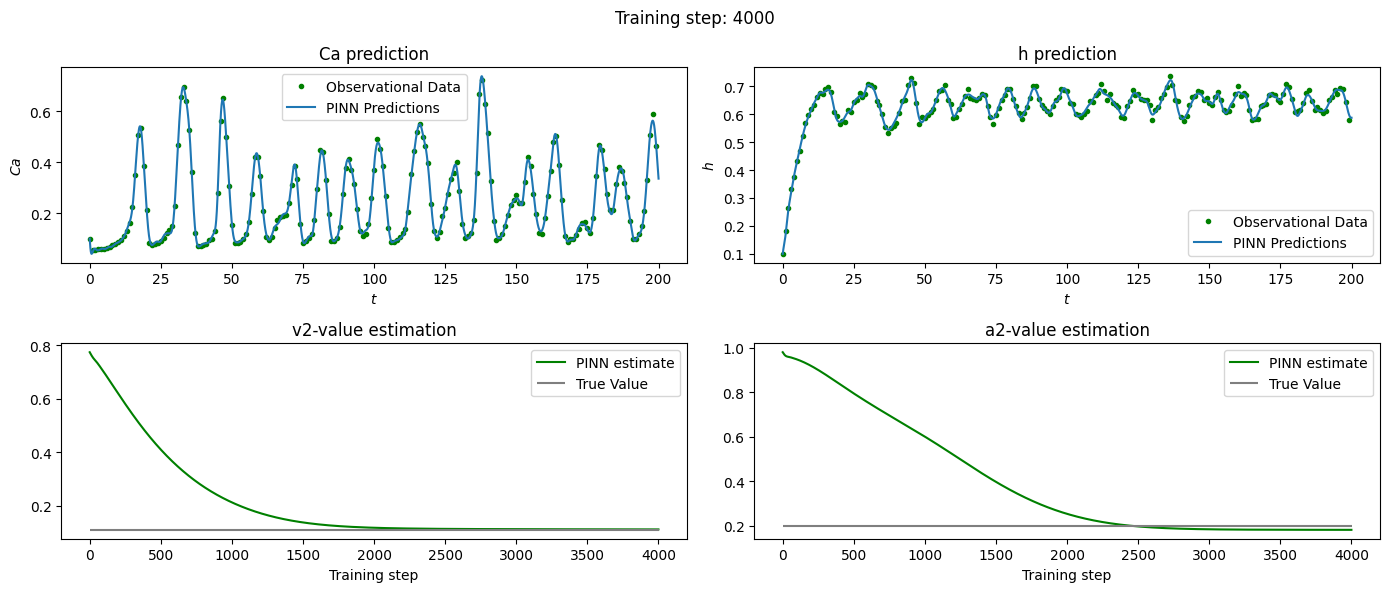

Epoch = 5000 | Loss = 4.090097718290053e-06 | Physics_loss = 0.00023362503270618618 | Initial_loss = 0.0 | Data_loss = 0.0001594406639924273


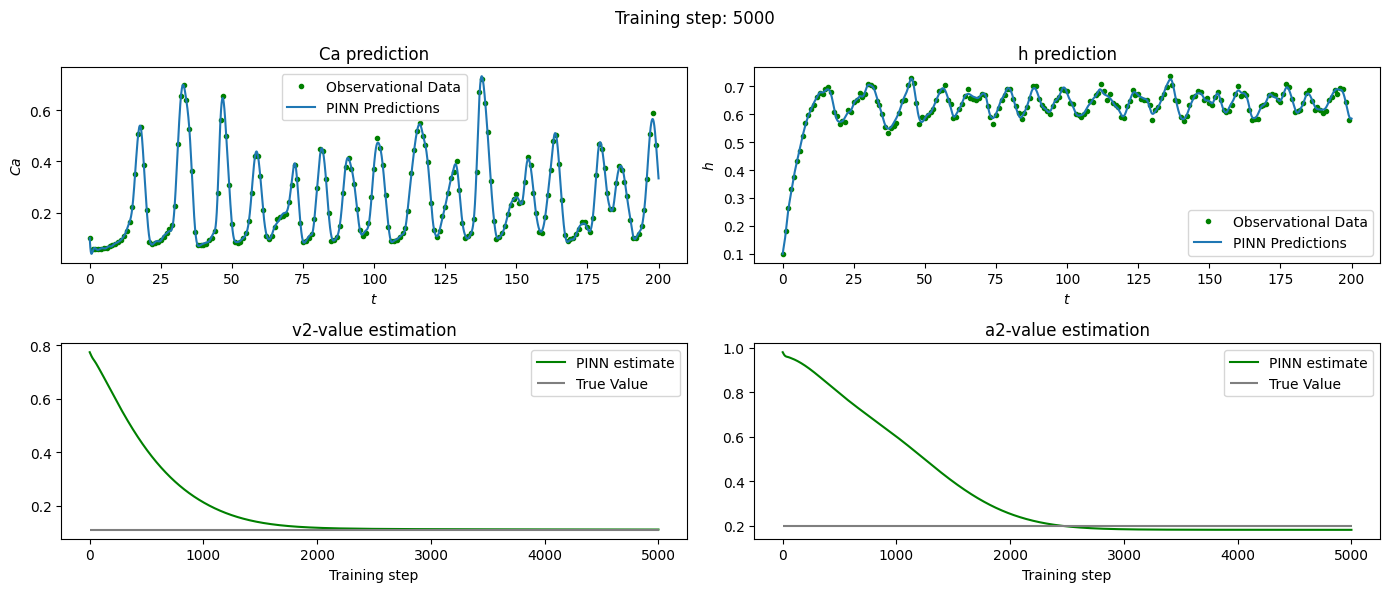

Epoch = 6000 | Loss = 3.6721273772855056e-06 | Physics_loss = 0.0002140721189789474 | Initial_loss = 0.0 | Data_loss = 0.0001392187550663948


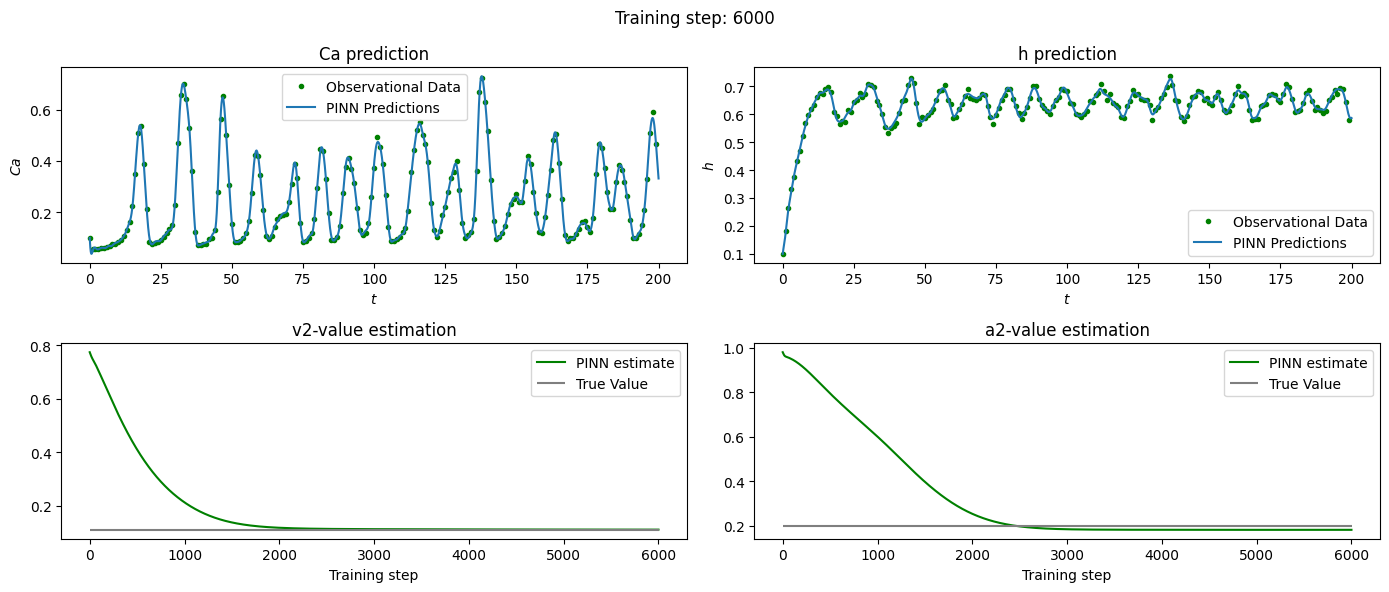

Epoch = 7000 | Loss = 3.92727815778926e-06 | Physics_loss = 0.00023994869843591005 | Initial_loss = 0.0 | Data_loss = 0.00013889011461287737


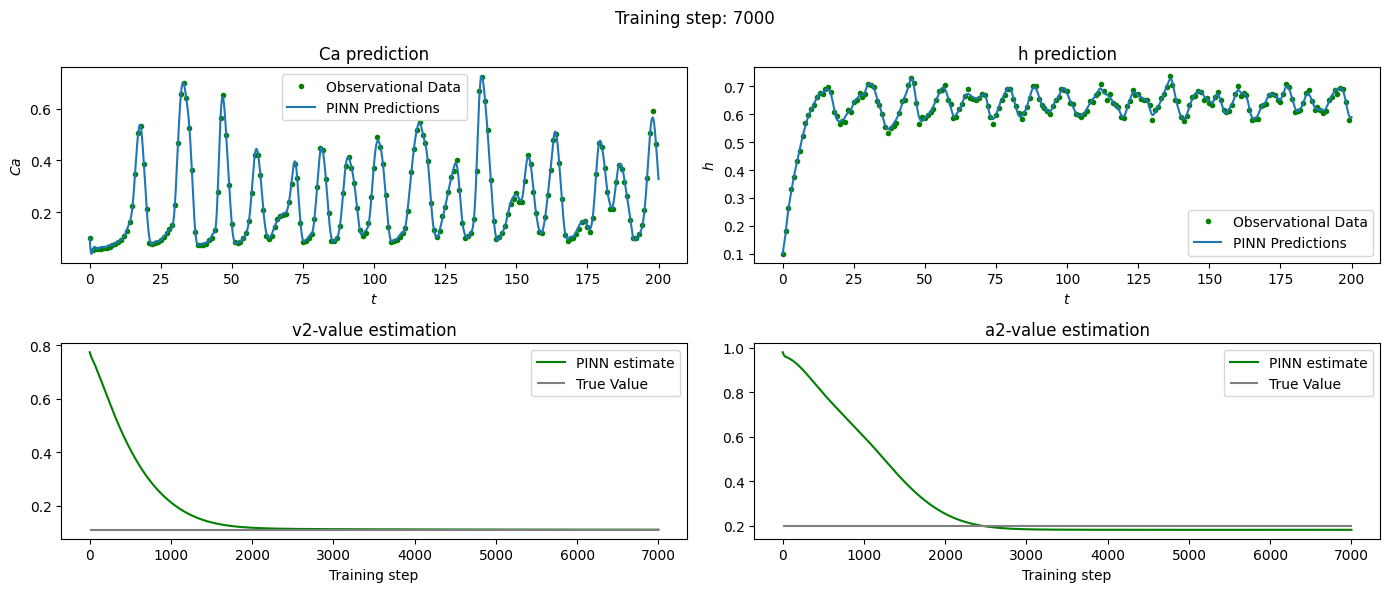

Epoch = 8000 | Loss = 3.527025683069951e-06 | Physics_loss = 0.00021469905914273113 | Initial_loss = 0.0 | Data_loss = 0.00012545775098260492


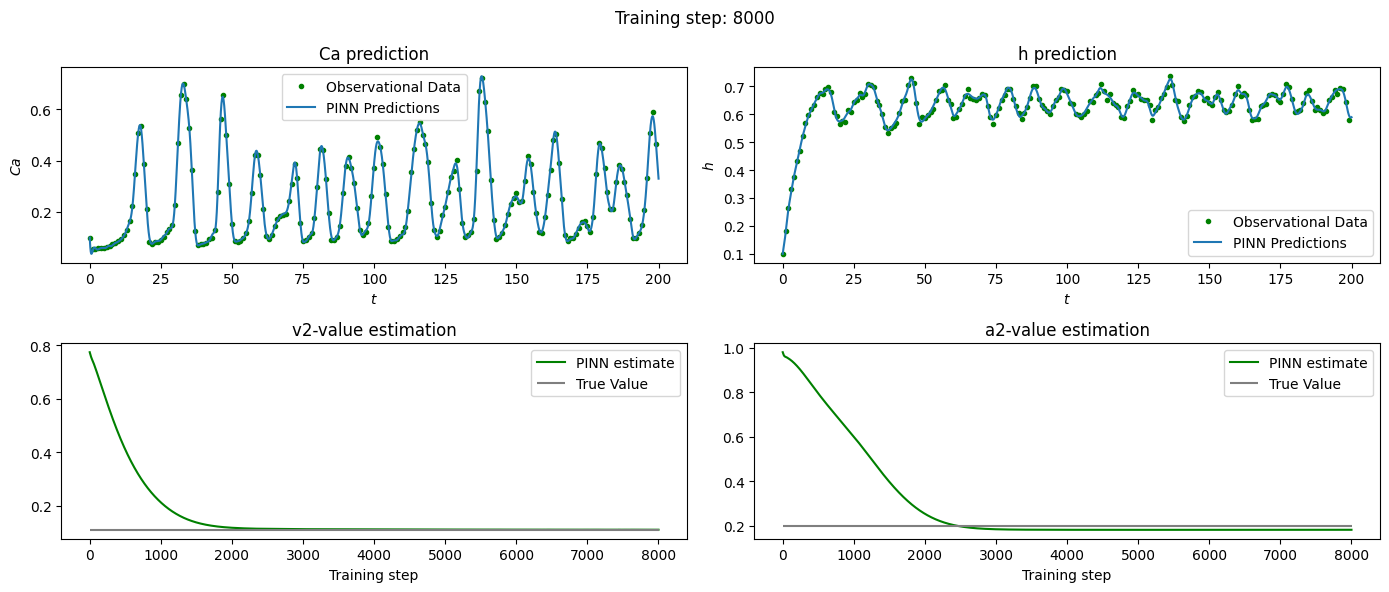

Epoch = 9000 | Loss = 3.4811287150660064e-06 | Physics_loss = 0.000217154054553248 | Initial_loss = 0.0 | Data_loss = 0.00011905348219443113


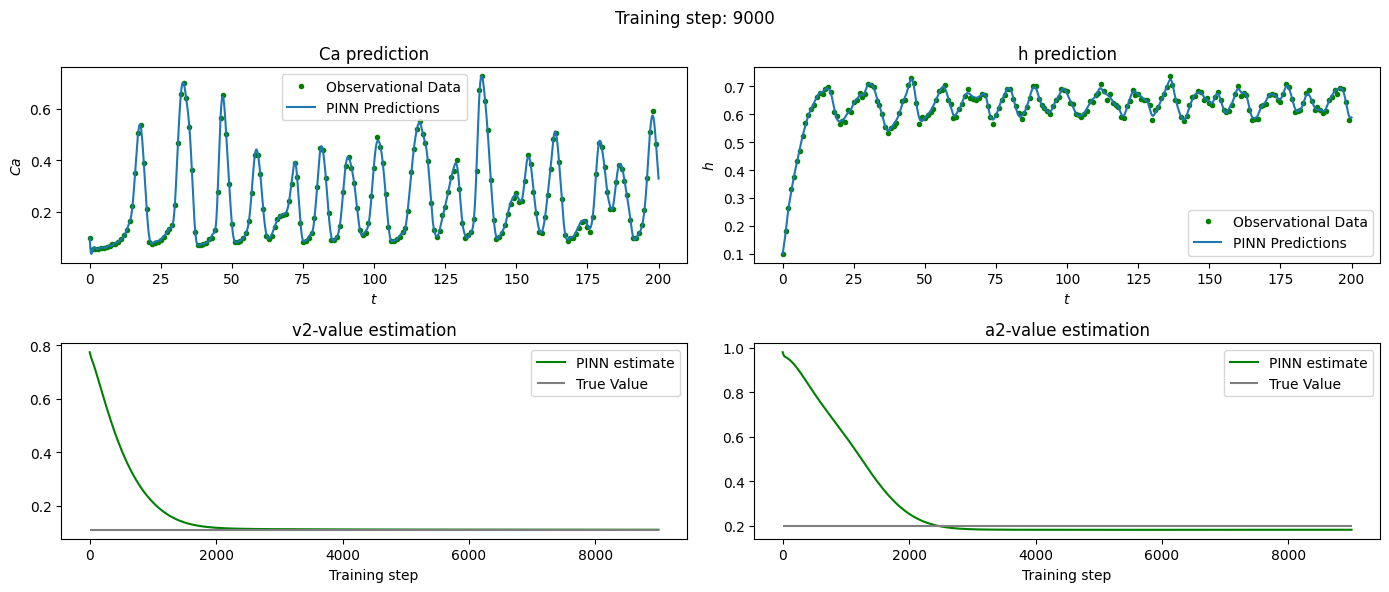

Epoch = 10000 | Loss = 4.255573458067374e-06 | Physics_loss = 0.00027766916900873184 | Initial_loss = 0.0 | Data_loss = 0.00013444380601868033


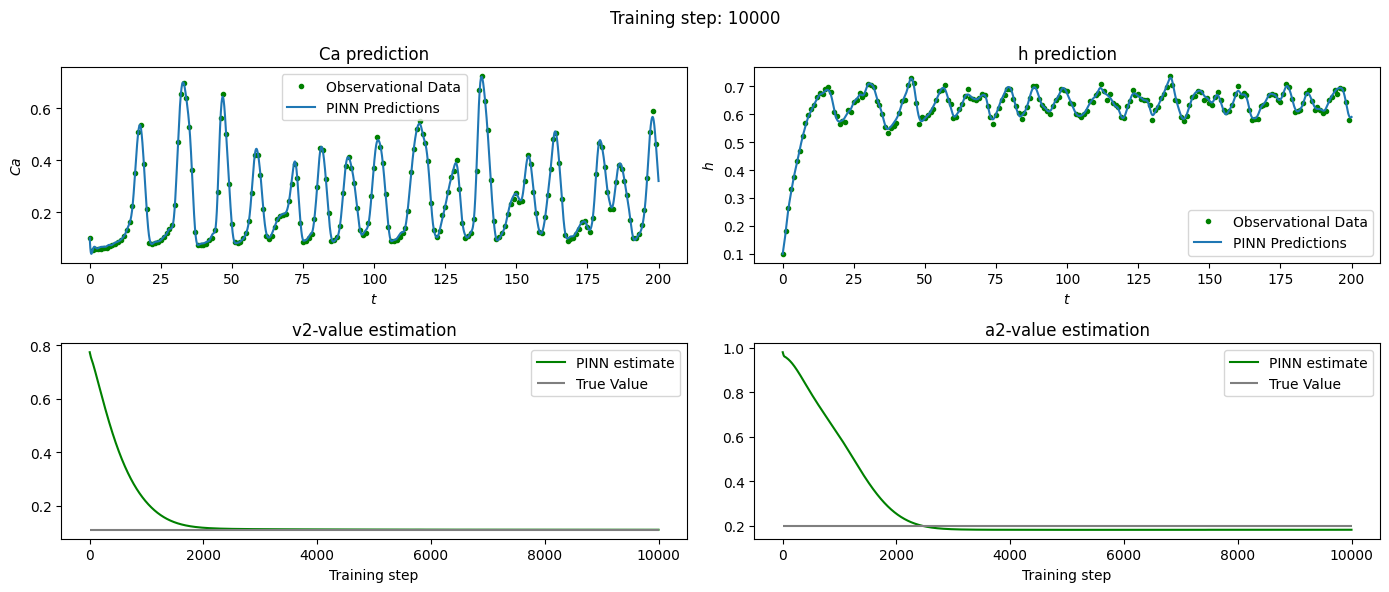

In [146]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.0823
k3  = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.11
#a2 = 0.2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1.1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

phy_loss = []
data_loss = []
total_loss = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - y02[0])**2
    loss4 = (torch.squeeze(h0) - y02[1])**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
       phy_loss.append(loss5 + loss6)
       data_loss.append(loss1 + loss2)
       total_loss.append(loss1+ loss2 + loss5 + loss6)

    if i % 1000 == 0:
        print(f"Epoch = {i} | Loss = {loss} | Physics_loss = {loss5 + loss6} | Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")
        
        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.11, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.2, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [113]:
v2s[-1], a2s[-1]

(0.11048221588134766, 0.1819847971200943)

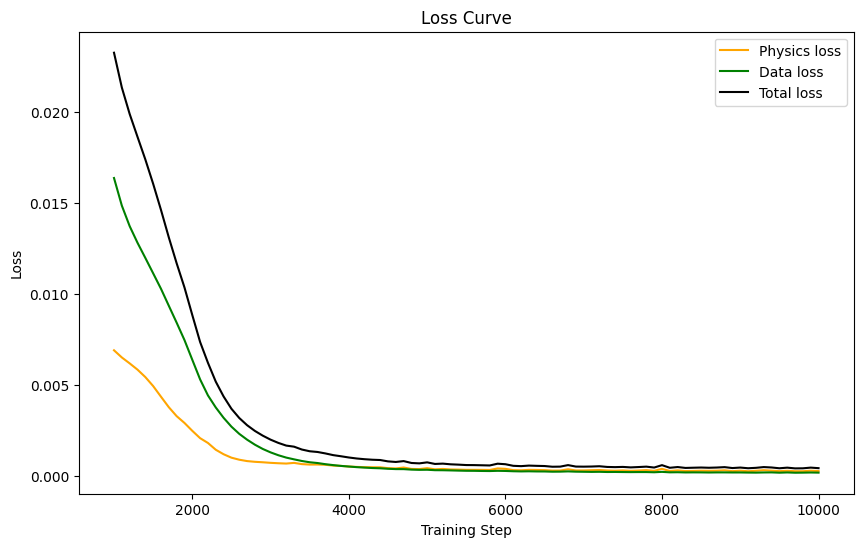

In [114]:
steps = np.linspace(0, 10000, 101)

plt.figure(figsize=(10, 6))
plt.plot(steps[10:], torch.tensor(phy_loss)[10:].detach().numpy(), label="Physics loss", c="orange")
plt.plot(steps[10:], torch.tensor(data_loss)[10:].detach().numpy(), label="Data loss", c="green")
plt.plot(steps[10:], torch.tensor(total_loss)[10:].detach().numpy(), label="Total loss", c="Black")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## **Stochastic Data - 2**

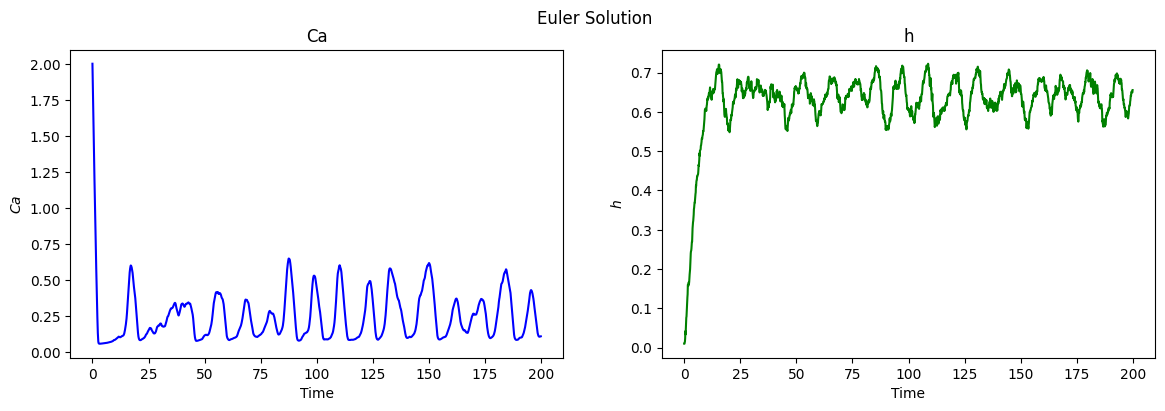

In [ ]:
np.random.seed(5)
P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([0.1, 0.1])
y = np.zeros((2, num_steps))
y[:, 0] = y02

for n in range(num_steps - 1):
    f = model_stochastic(t[n], y[:, n], P, dt)
    y[:, n + 1] = y[:, n] + dt * f

Ca_non_stoch, h_non_stoch = y

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_non_stoch, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_non_stoch, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Epoch = 0 | Loss = 0.05368351936340332 | Physics_loss = 1.6836248636245728 | Initial_loss = 0.0 | Data_loss = 3.684727191925049


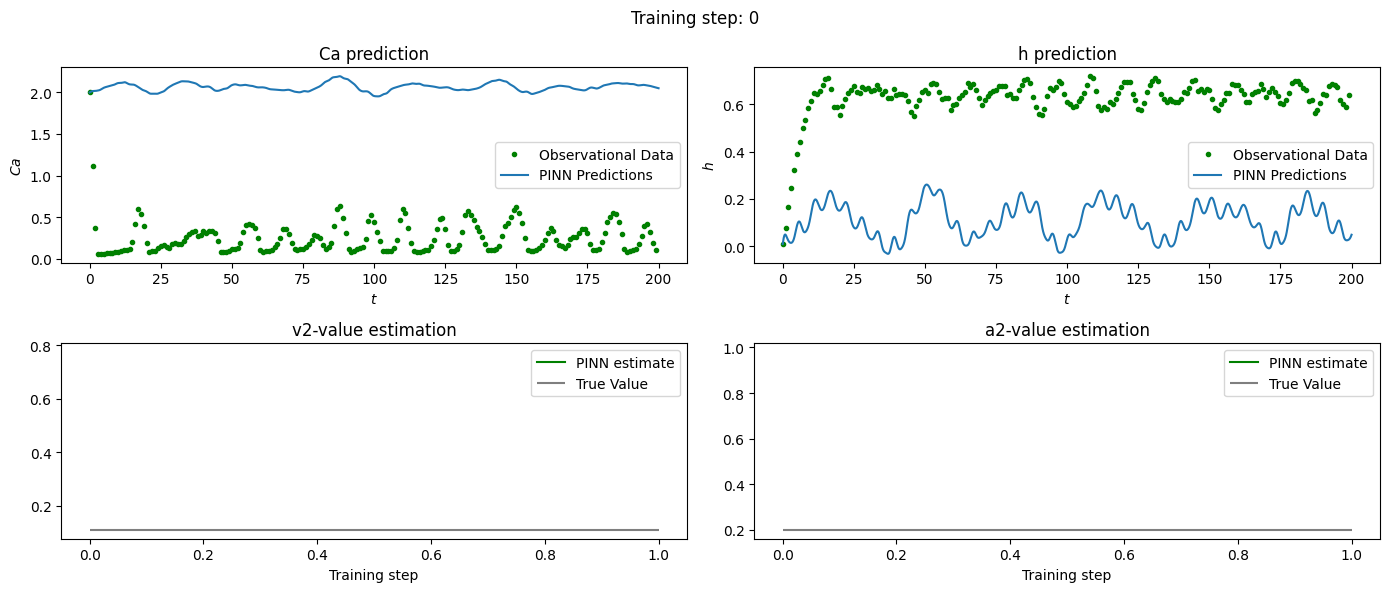

Epoch = 1000 | Loss = 0.00023786150268279016 | Physics_loss = 0.006804883945733309 | Initial_loss = 0.0 | Data_loss = 0.01698126643896103


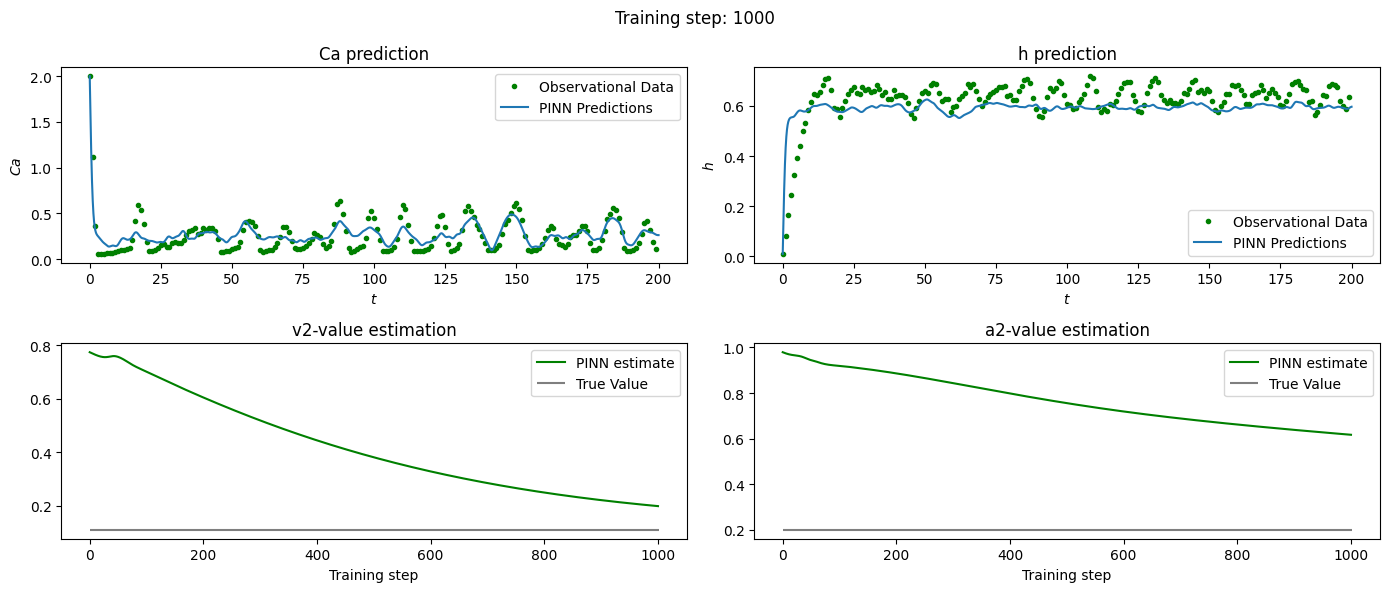

Epoch = 2000 | Loss = 0.00011123105650767684 | Physics_loss = 0.003797826124355197 | Initial_loss = 0.0 | Data_loss = 0.007325279992073774


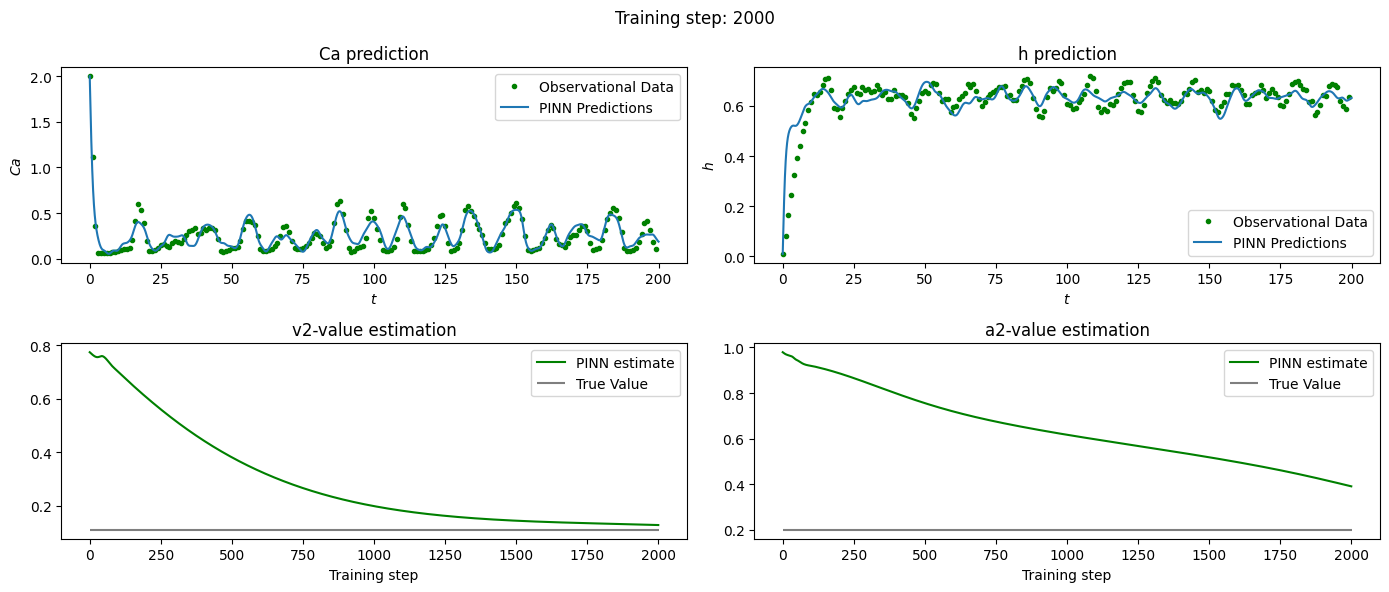

Epoch = 3000 | Loss = 1.9967477783211507e-05 | Physics_loss = 0.0008470512693747878 | Initial_loss = 0.0 | Data_loss = 0.0011496965307742357


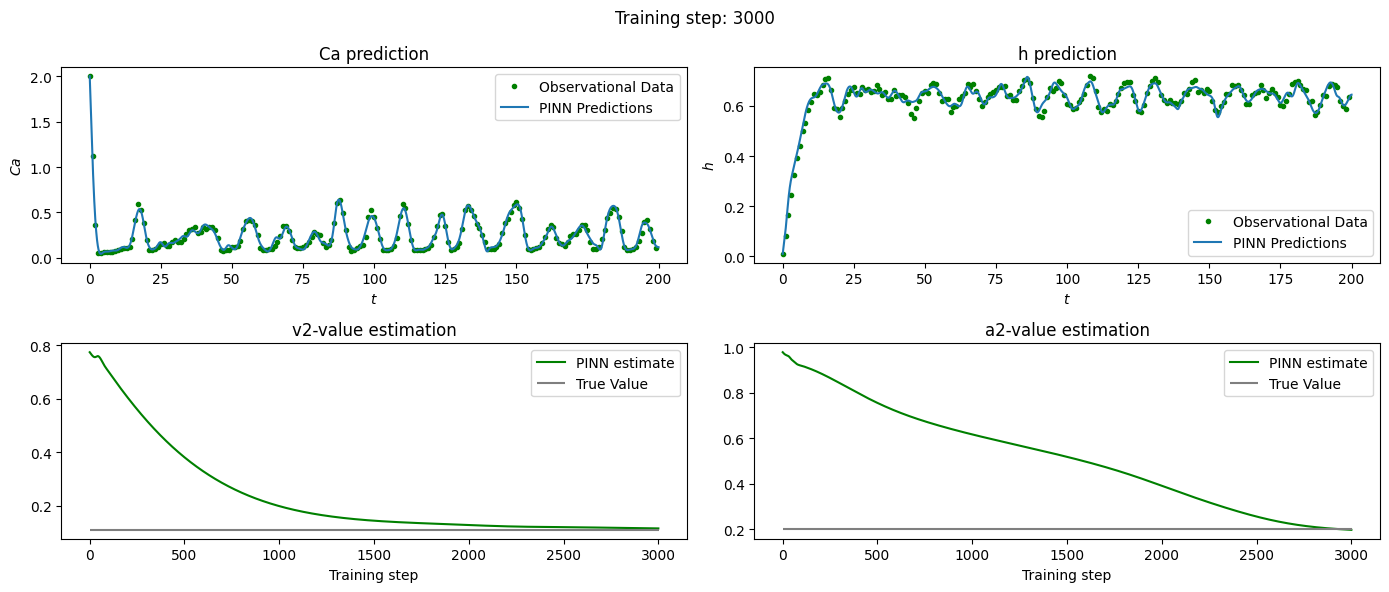

Epoch = 4000 | Loss = 9.333134585176595e-06 | Physics_loss = 0.00045158102875575423 | Initial_loss = 0.0 | Data_loss = 0.0004817324806936085


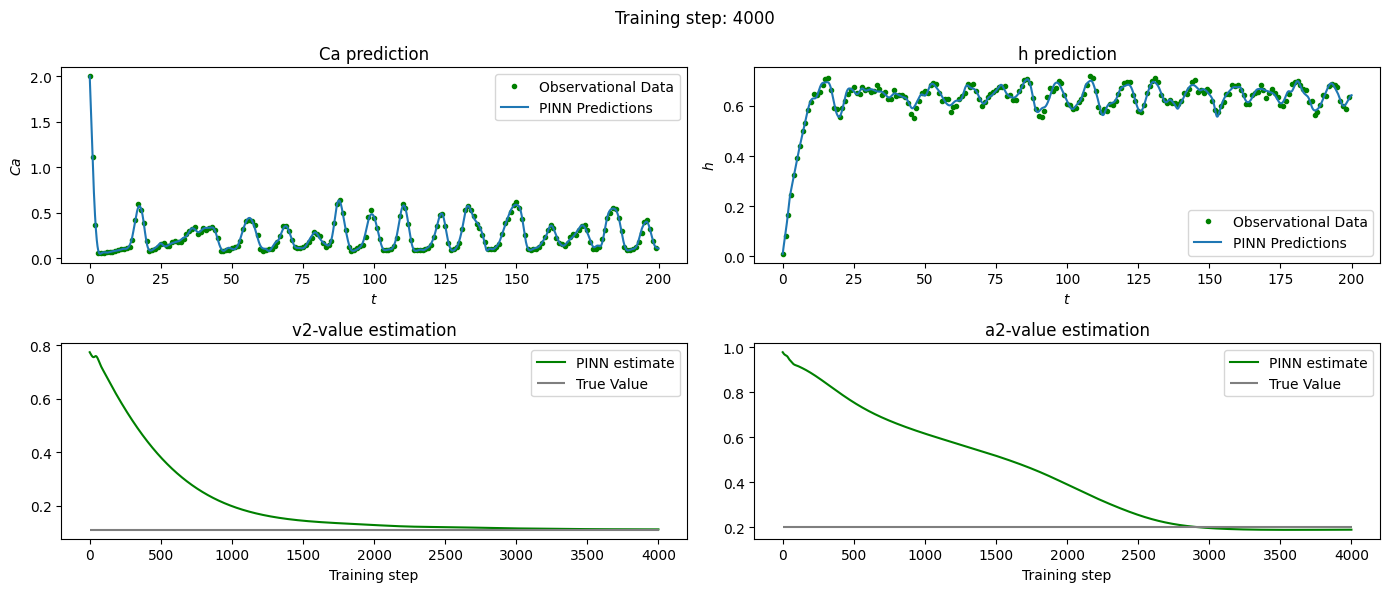

Epoch = 5000 | Loss = 6.363713055179687e-06 | Physics_loss = 0.0003294069319963455 | Initial_loss = 0.0 | Data_loss = 0.000306964386254549


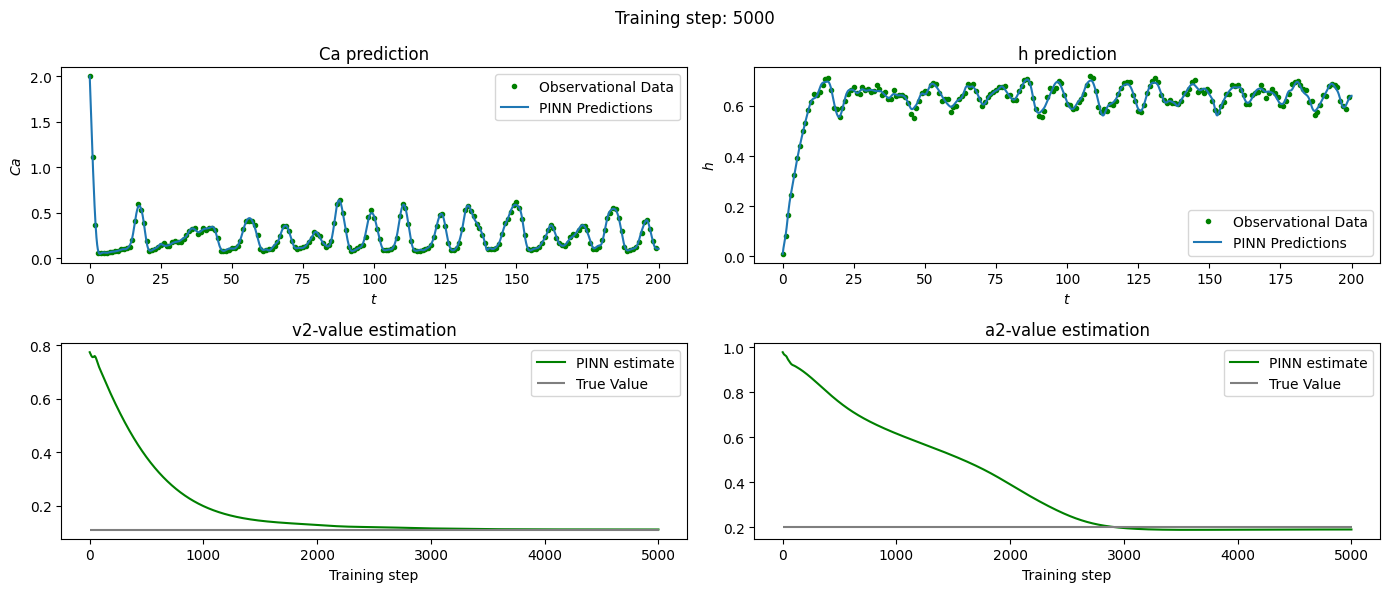

Epoch = 6000 | Loss = 5.08541506860638e-06 | Physics_loss = 0.00027634442085400224 | Initial_loss = 0.0 | Data_loss = 0.00023219706781674176


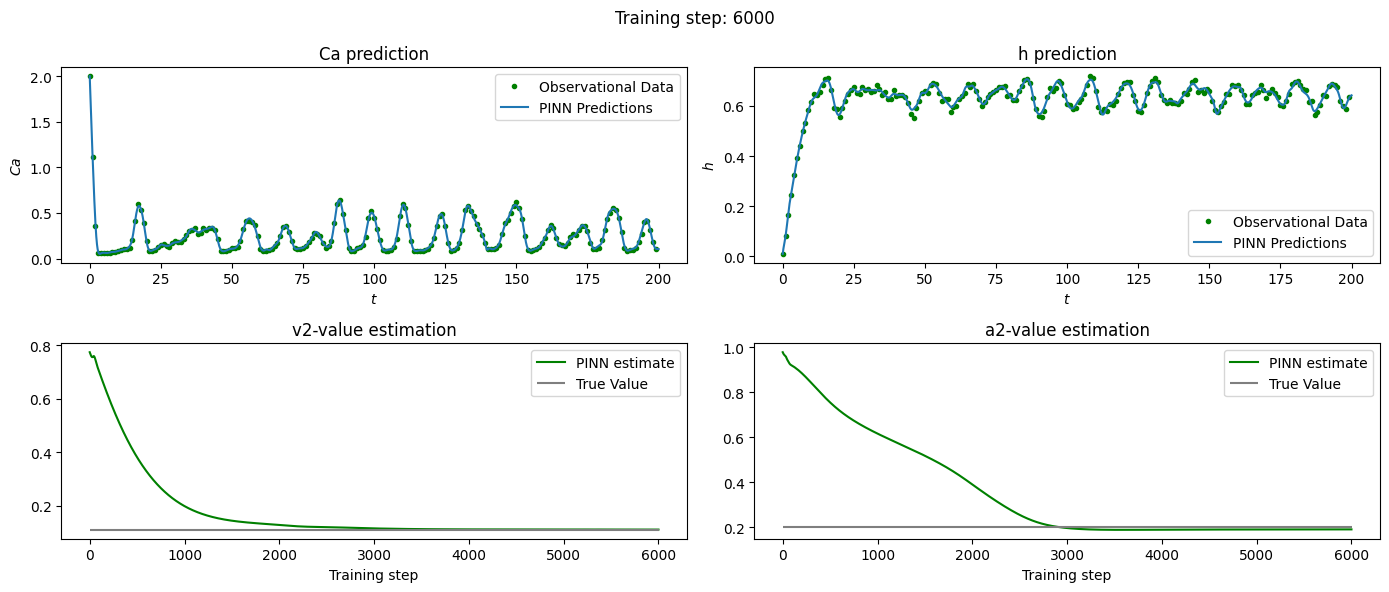

Epoch = 7000 | Loss = 4.199622708256356e-06 | Physics_loss = 0.00023022011737339199 | Initial_loss = 0.0 | Data_loss = 0.0001897421316243708


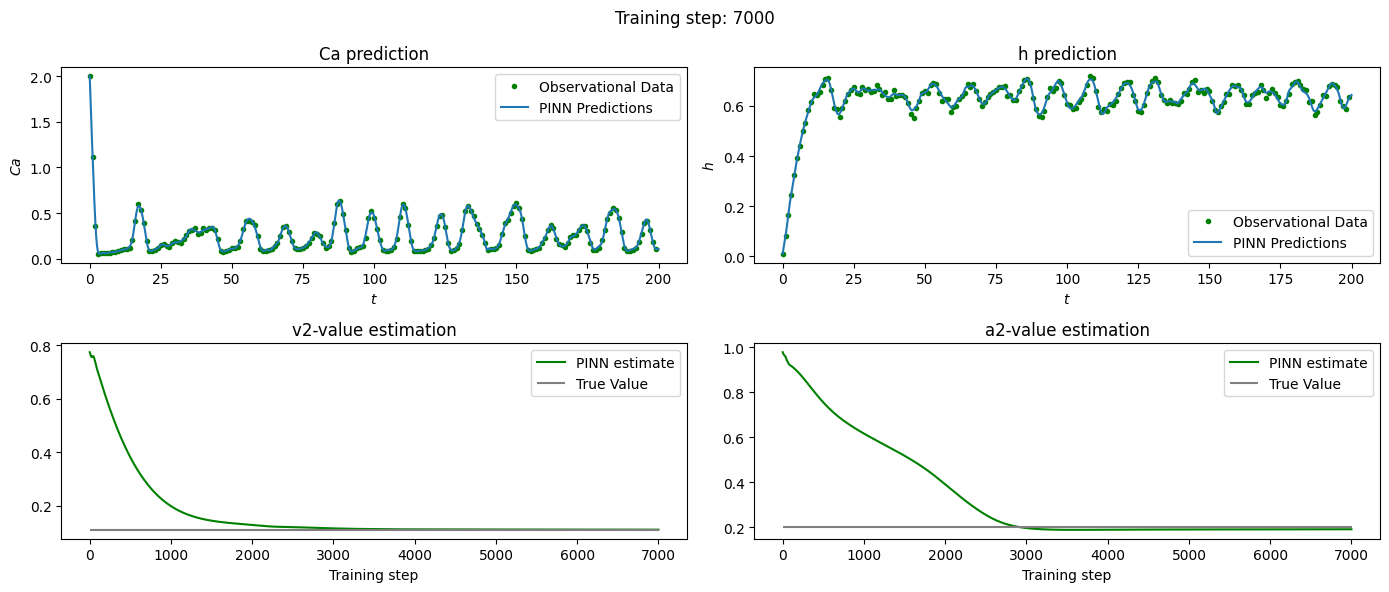

Epoch = 8000 | Loss = 4.260703917680075e-06 | Physics_loss = 0.00024919735733419657 | Initial_loss = 0.0 | Data_loss = 0.00017687305808067322


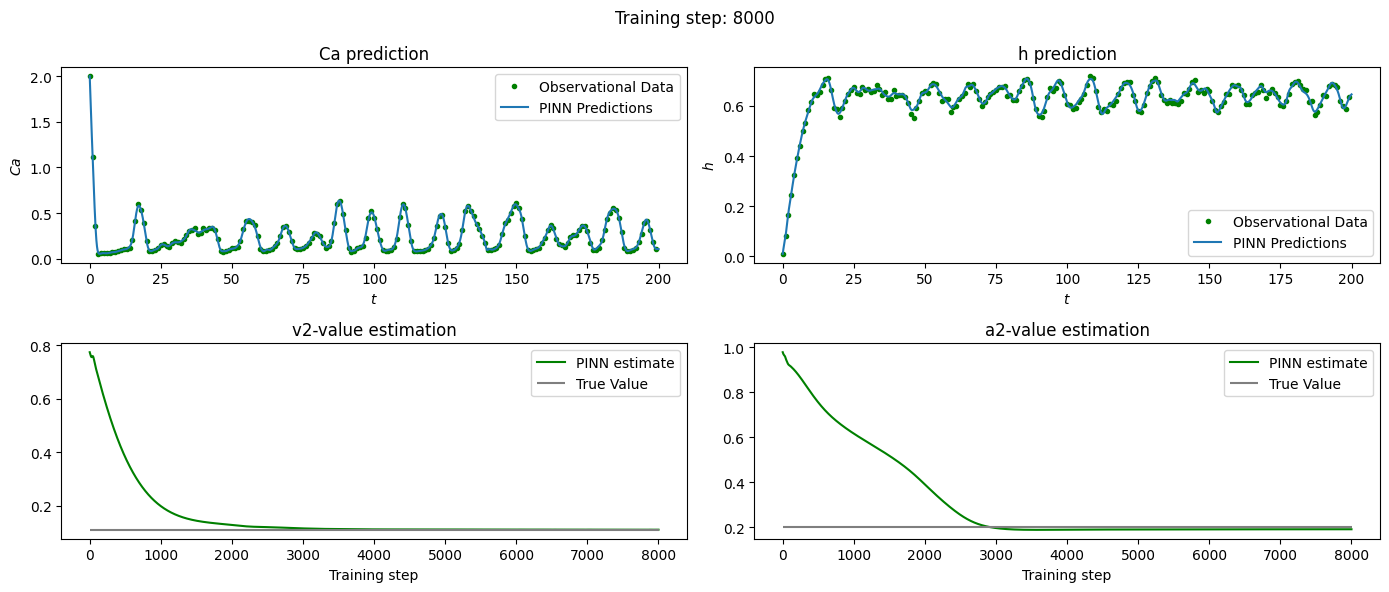

Epoch = 9000 | Loss = 4.319963409216143e-06 | Physics_loss = 0.0002599199942778796 | Initial_loss = 0.0 | Data_loss = 0.00017207635391969234


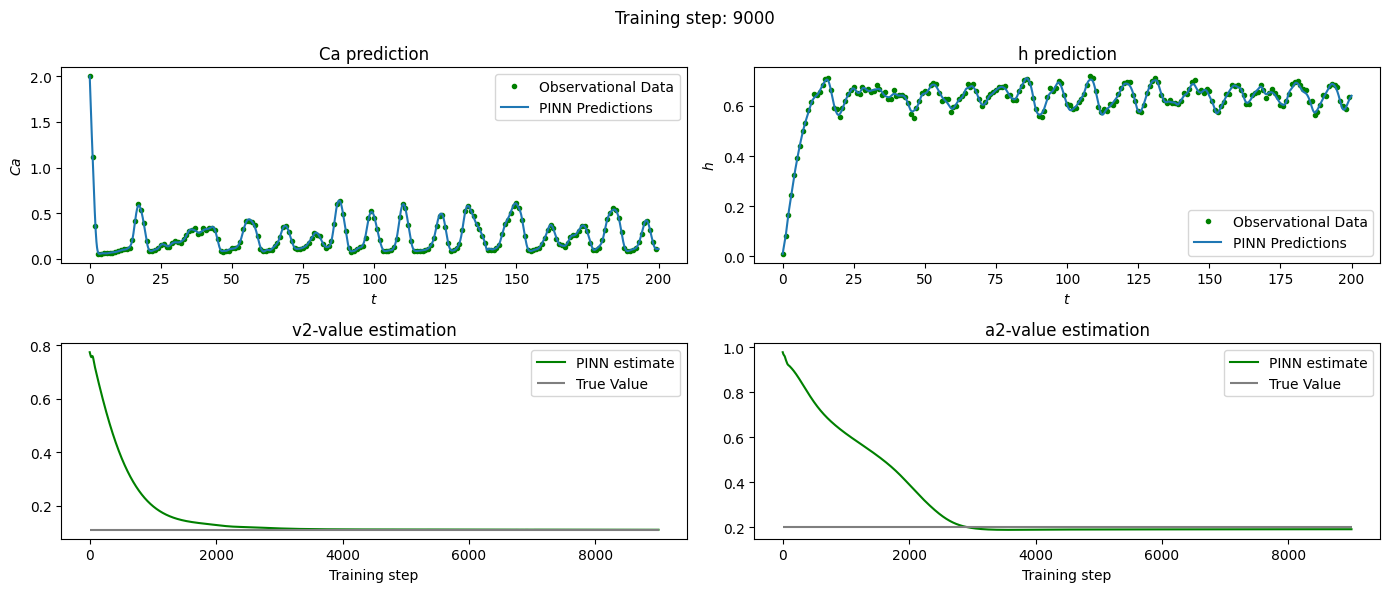

Epoch = 10000 | Loss = 3.307572114863433e-06 | Physics_loss = 0.0001910357386805117 | Initial_loss = 0.0 | Data_loss = 0.00013972149463370442


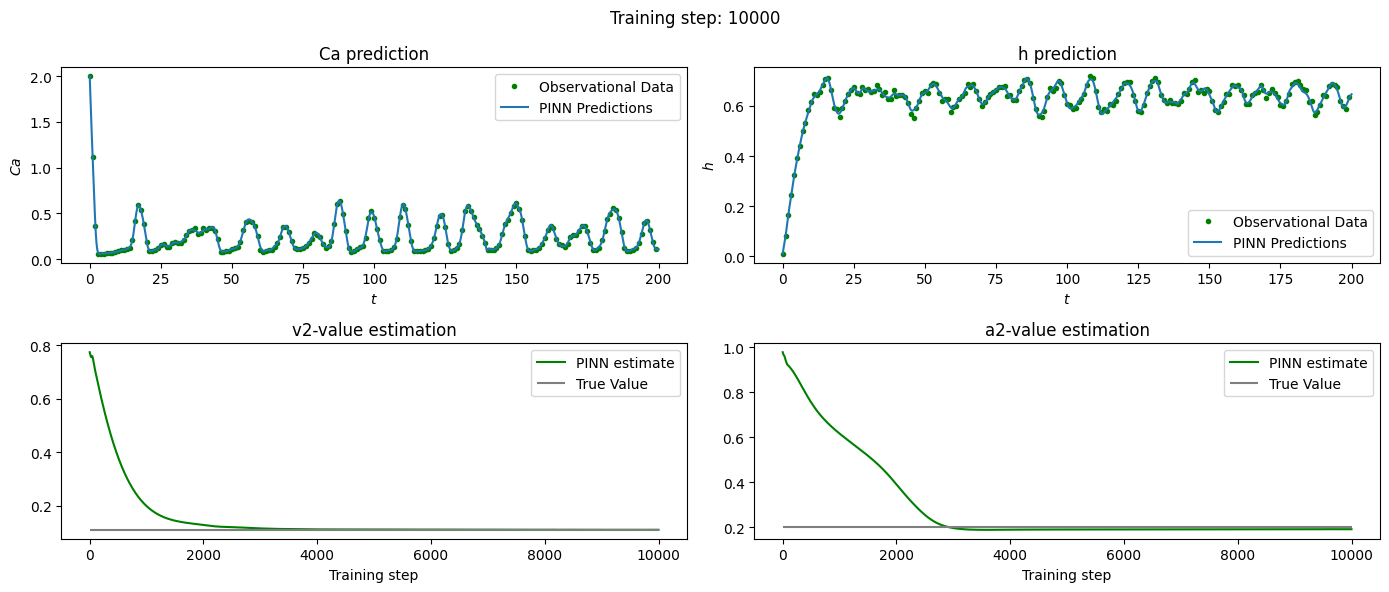

In [117]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.0823
k3  = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.11
#a2 = 0.2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

phy_loss = []
data_loss = []
total_loss = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - y02[0])**2
    loss4 = (torch.squeeze(h0) - y02[1])**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
       phy_loss.append(loss5 + loss6)
       data_loss.append(loss1 + loss2)
       total_loss.append(loss1+ loss2 + loss5 + loss6)

    if i % 1000 == 0:
        print(f"Epoch = {i} | Loss = {loss} | Physics_loss = {loss5 + loss6} | Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.11, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.2, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [118]:
v2s[-1], a2s[-1]

(0.11015245318412781, 0.19170385599136353)

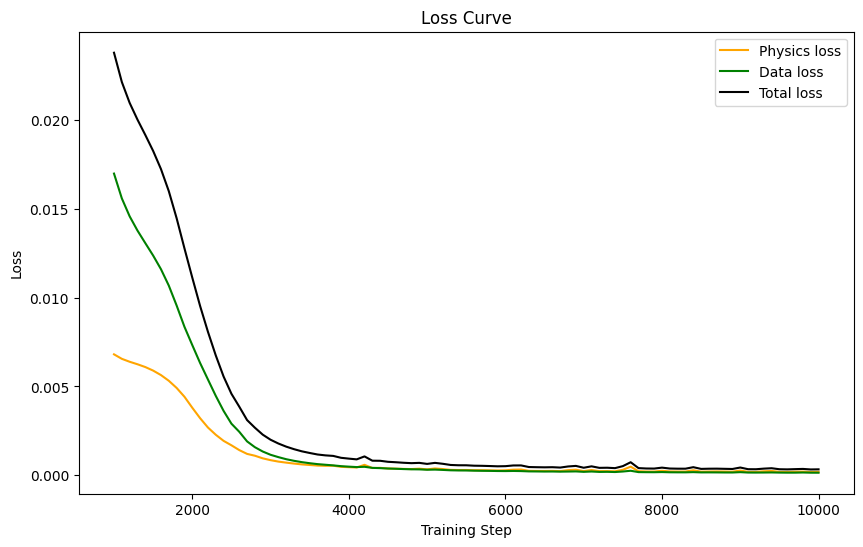

In [119]:
steps = np.linspace(0, 10000, 101)

plt.figure(figsize=(10, 6))
plt.plot(steps[10:], torch.tensor(phy_loss)[10:].detach().numpy(), label="Physics loss", c="orange")
plt.plot(steps[10:], torch.tensor(data_loss)[10:].detach().numpy(), label="Data loss", c="green")
plt.plot(steps[10:], torch.tensor(total_loss)[10:].detach().numpy(), label="Total loss", c="Black")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## **Stochastic Data - 3**

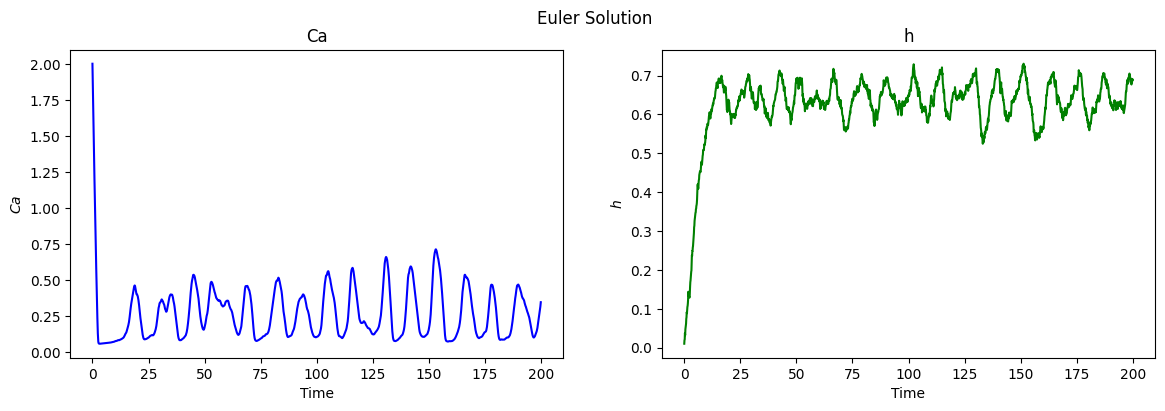

In [ ]:
np.random.seed(10)
P = [0.5, 6, 0.11, 0.9, 0.2, 0.13,- 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([2.0, 0.01])
y = np.zeros((2, num_steps))
y[:, 0] = y02

for n in range(num_steps - 1):
    f = model_stochastic(t[n], y[:, n], P, dt)
    y[:, n + 1] = y[:, n] + dt * f

Ca_non_stoch, h_non_stoch = y

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_non_stoch, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_non_stoch, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Epoch = 0 | Loss = 0.05307689681649208 | Physics_loss = 1.6836248636245728 | Initial_loss = 0.0 | Data_loss = 3.6240649223327637


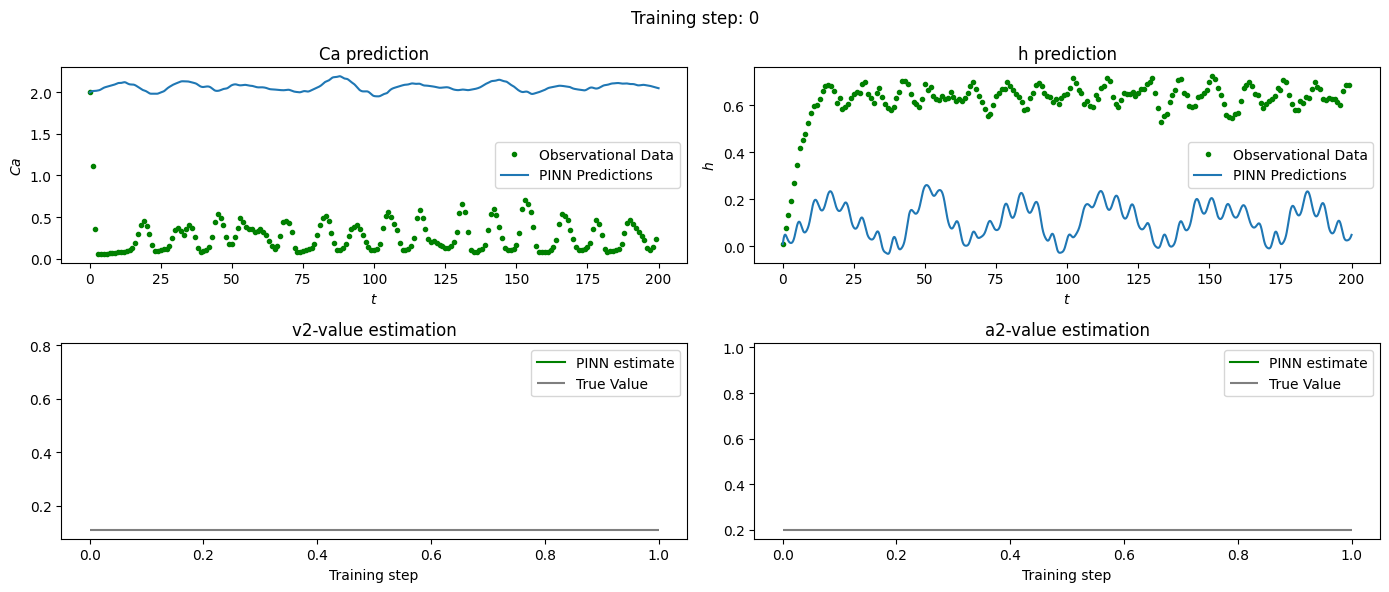

Epoch = 1000 | Loss = 0.0002674282295629382 | Physics_loss = 0.0063996086828410625 | Initial_loss = 0.0 | Data_loss = 0.02034321427345276


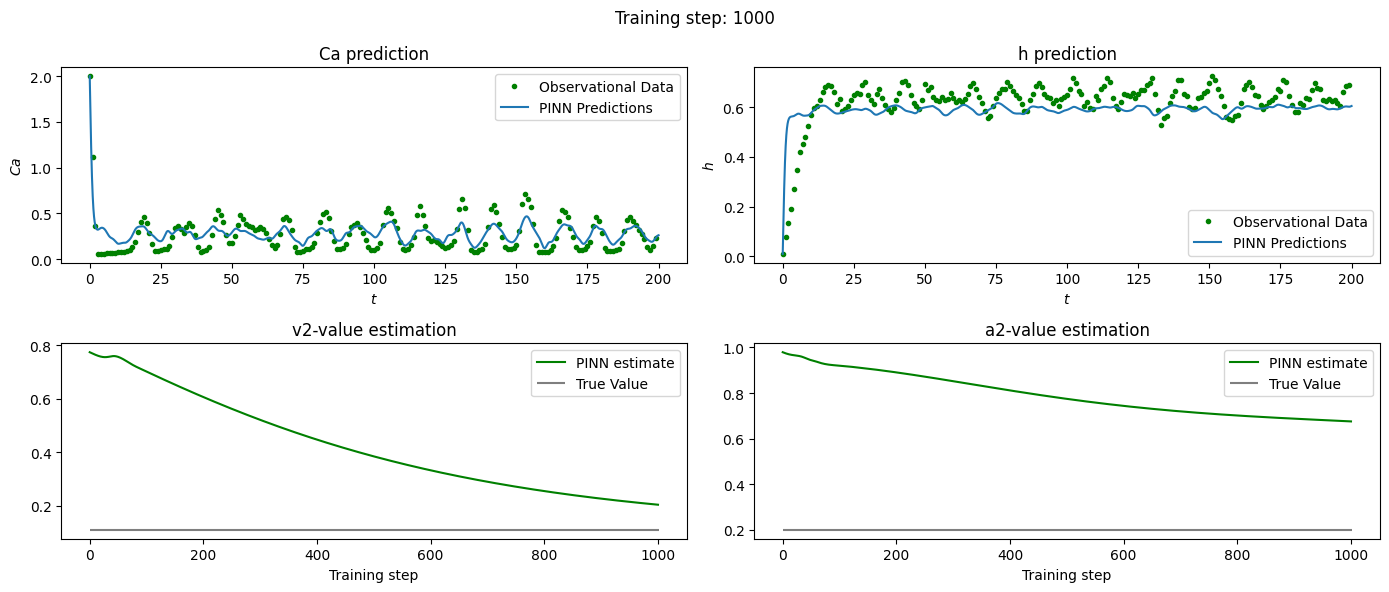

Epoch = 2000 | Loss = 0.00011177420674357563 | Physics_loss = 0.002340331906452775 | Initial_loss = 0.0 | Data_loss = 0.008837088942527771


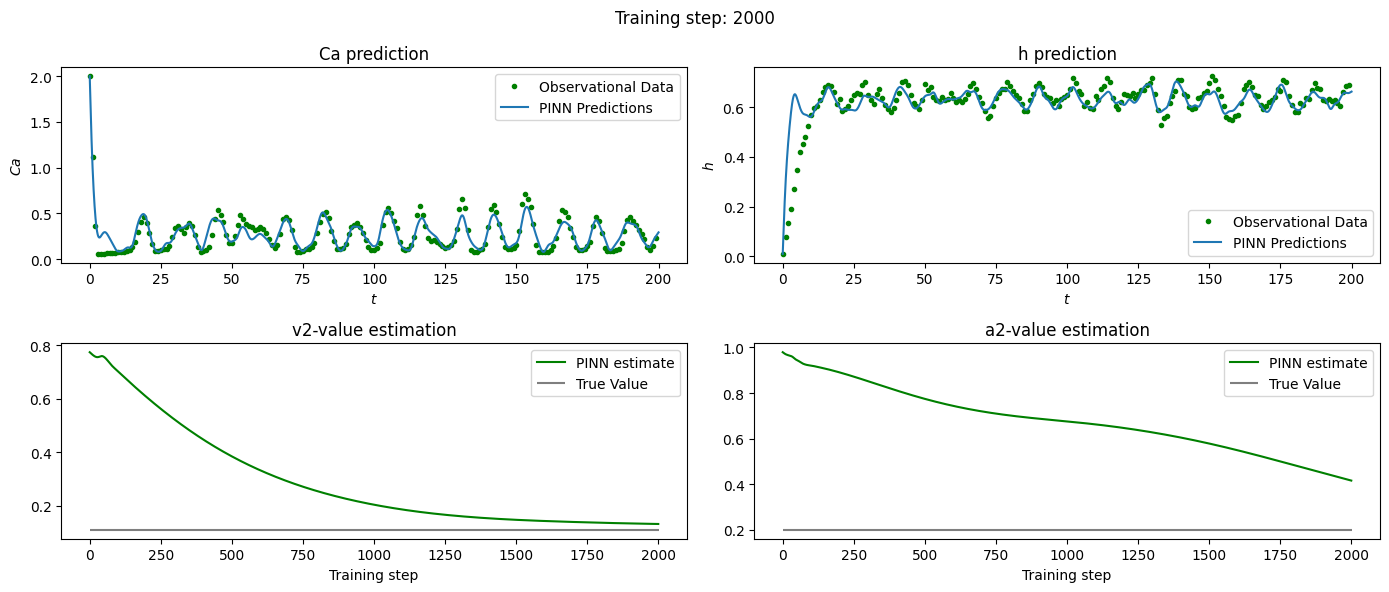

Epoch = 3000 | Loss = 2.0683753973571584e-05 | Physics_loss = 0.0006918060826137662 | Initial_loss = 0.0 | Data_loss = 0.0013765695039182901


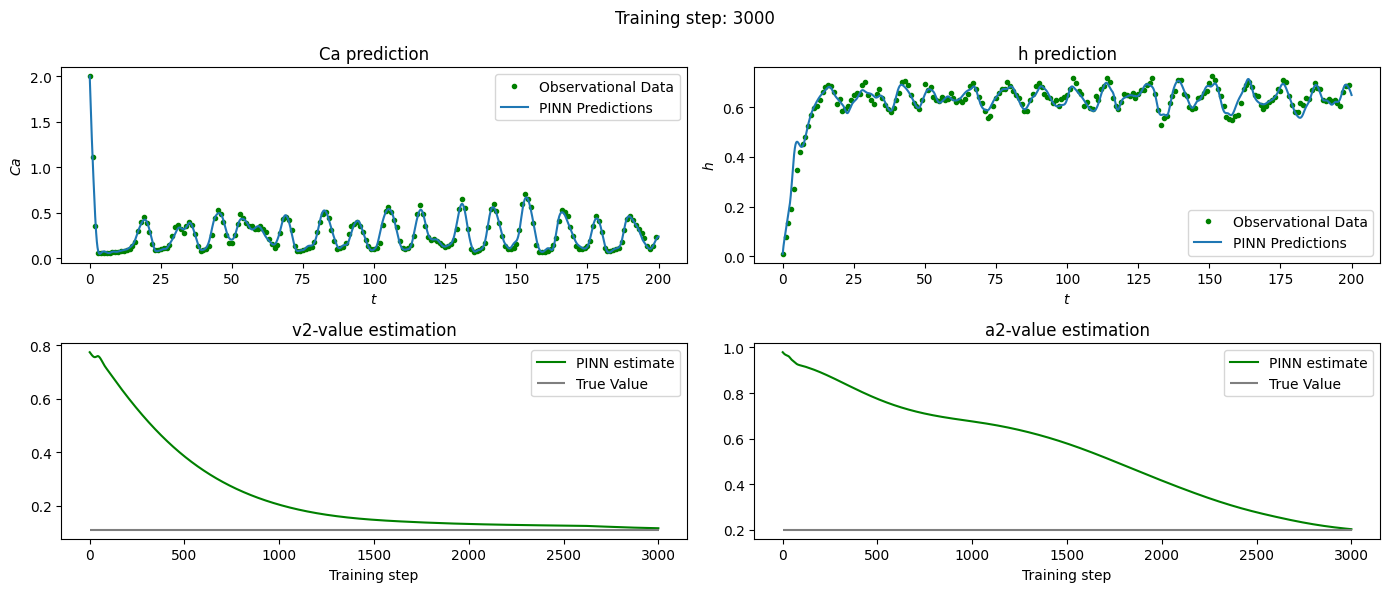

Epoch = 4000 | Loss = 6.655697688984219e-06 | Physics_loss = 0.00029360270127654076 | Initial_loss = 0.0 | Data_loss = 0.0003719670930877328


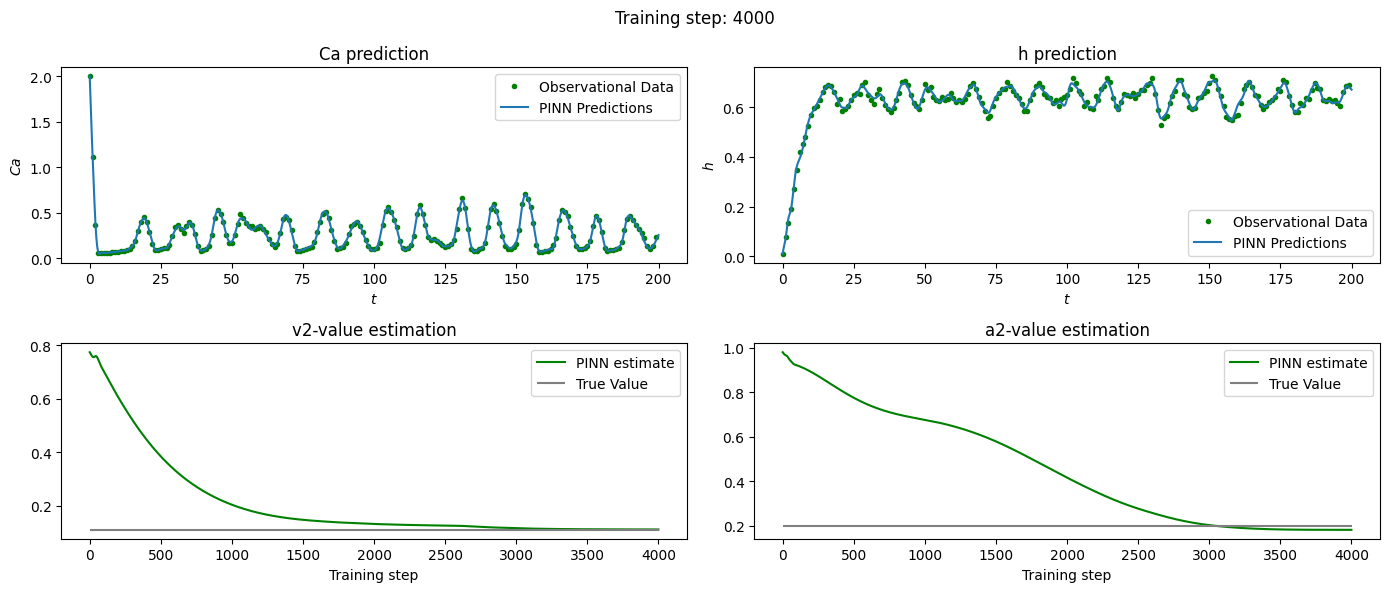

Epoch = 5000 | Loss = 5.352482276066439e-06 | Physics_loss = 0.00027926976326853037 | Initial_loss = 0.0 | Data_loss = 0.00025597846251912415


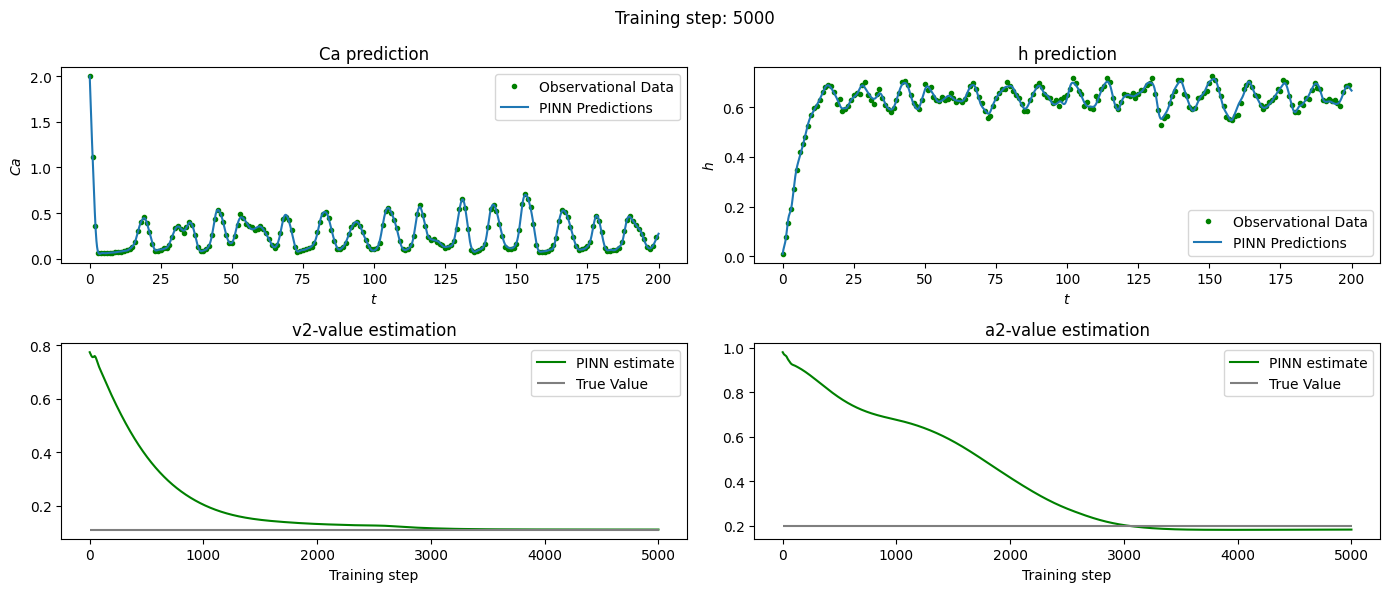

Epoch = 6000 | Loss = 4.0623481254442595e-06 | Physics_loss = 0.00020744983339682221 | Initial_loss = 0.0 | Data_loss = 0.000198785011889413


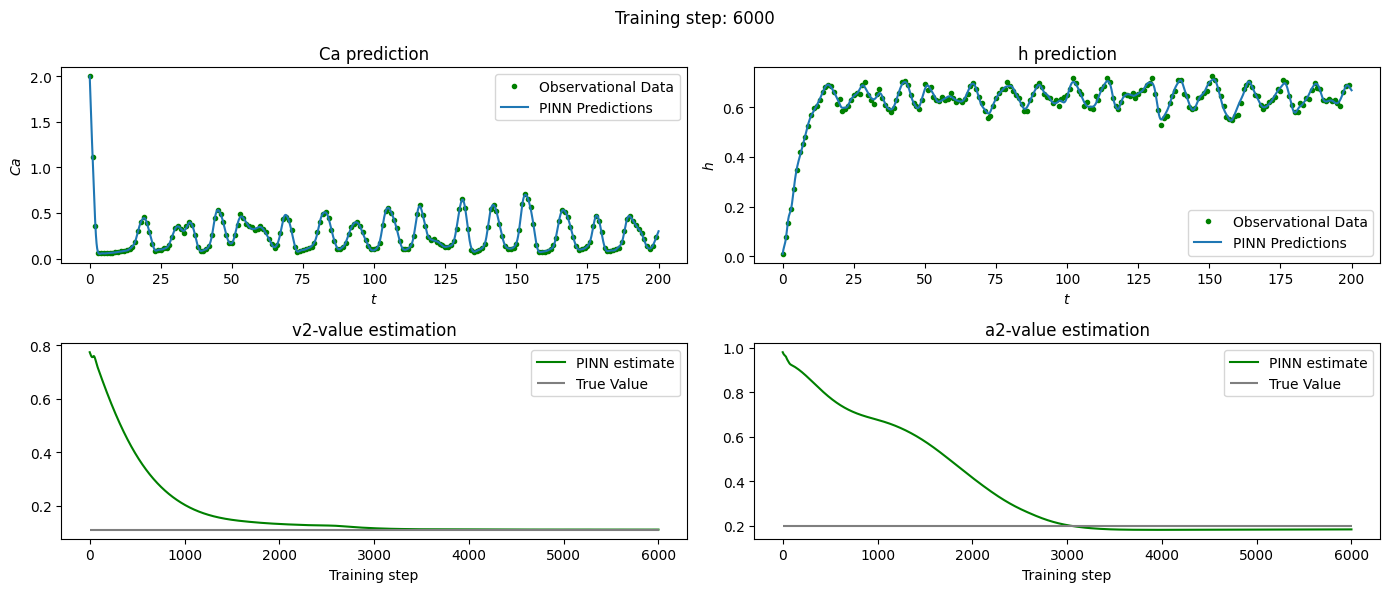

Epoch = 7000 | Loss = 4.574001650325954e-06 | Physics_loss = 0.0002638623700477183 | Initial_loss = 0.0 | Data_loss = 0.00019353776588104665


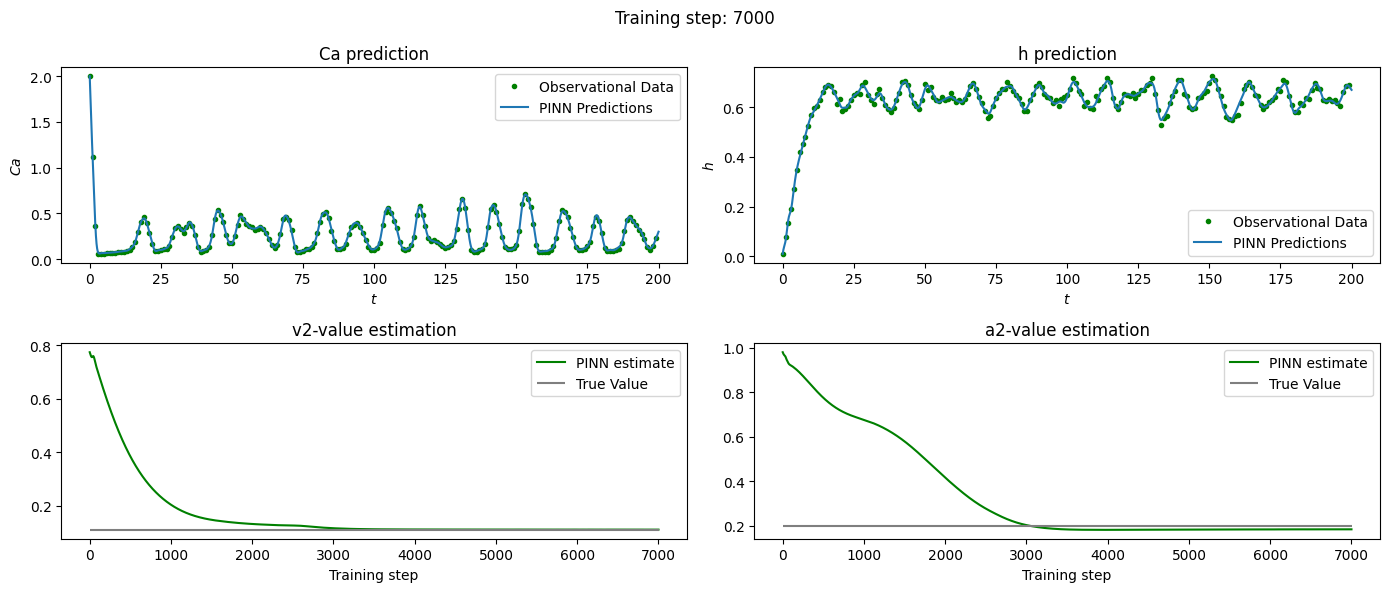

Epoch = 8000 | Loss = 3.3623002764215926e-06 | Physics_loss = 0.0001801960897864774 | Initial_loss = 0.0 | Data_loss = 0.00015603394422214478


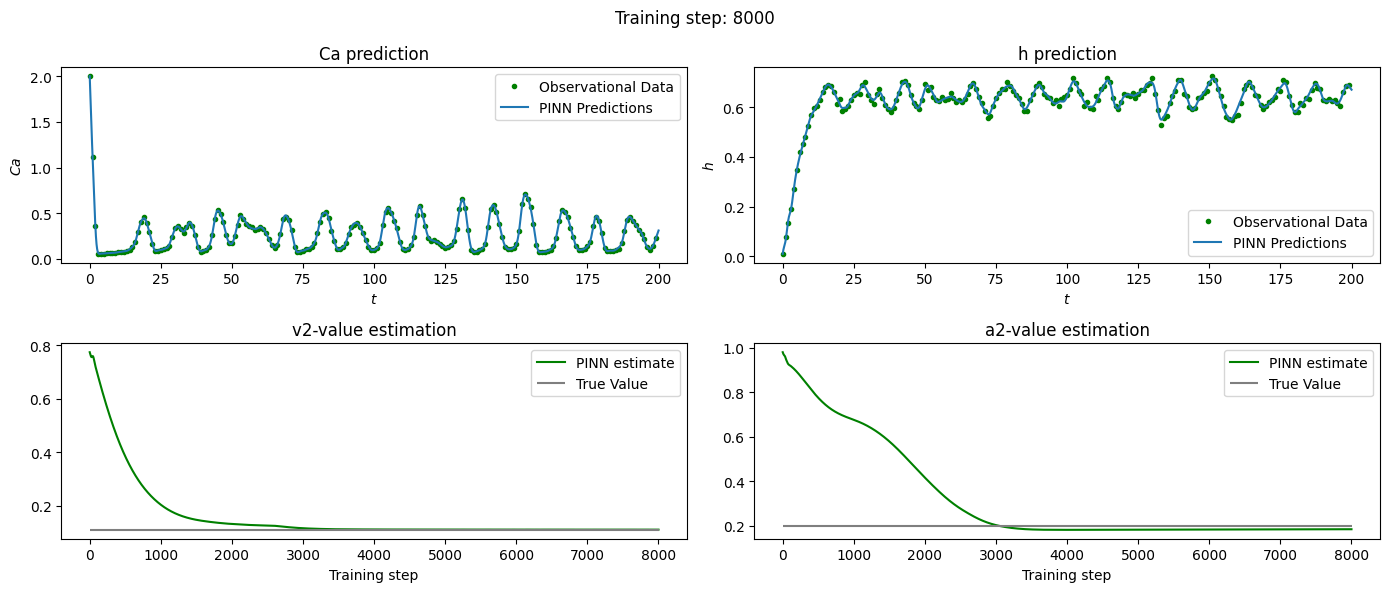

Epoch = 9000 | Loss = 3.574615220713895e-06 | Physics_loss = 0.00020510010654106736 | Initial_loss = 0.0 | Data_loss = 0.00015236143372021616


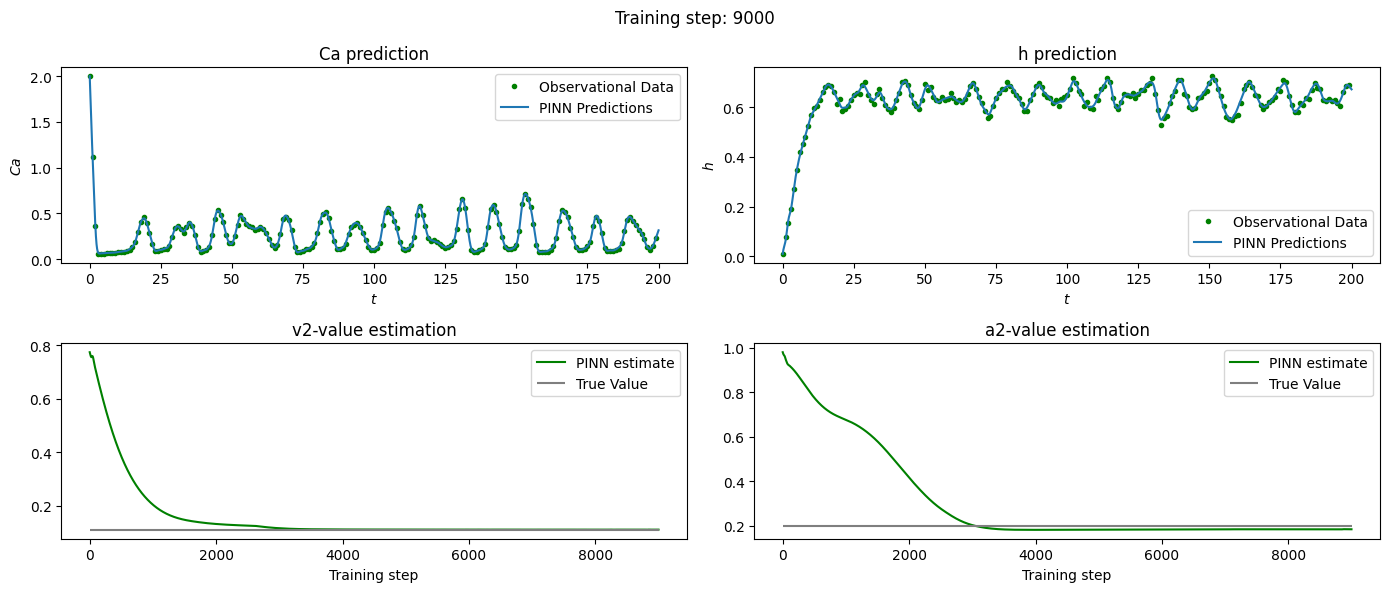

Epoch = 10000 | Loss = 3.933313564630225e-06 | Physics_loss = 0.0002318451734026894 | Initial_loss = 0.0 | Data_loss = 0.00016148622671607882


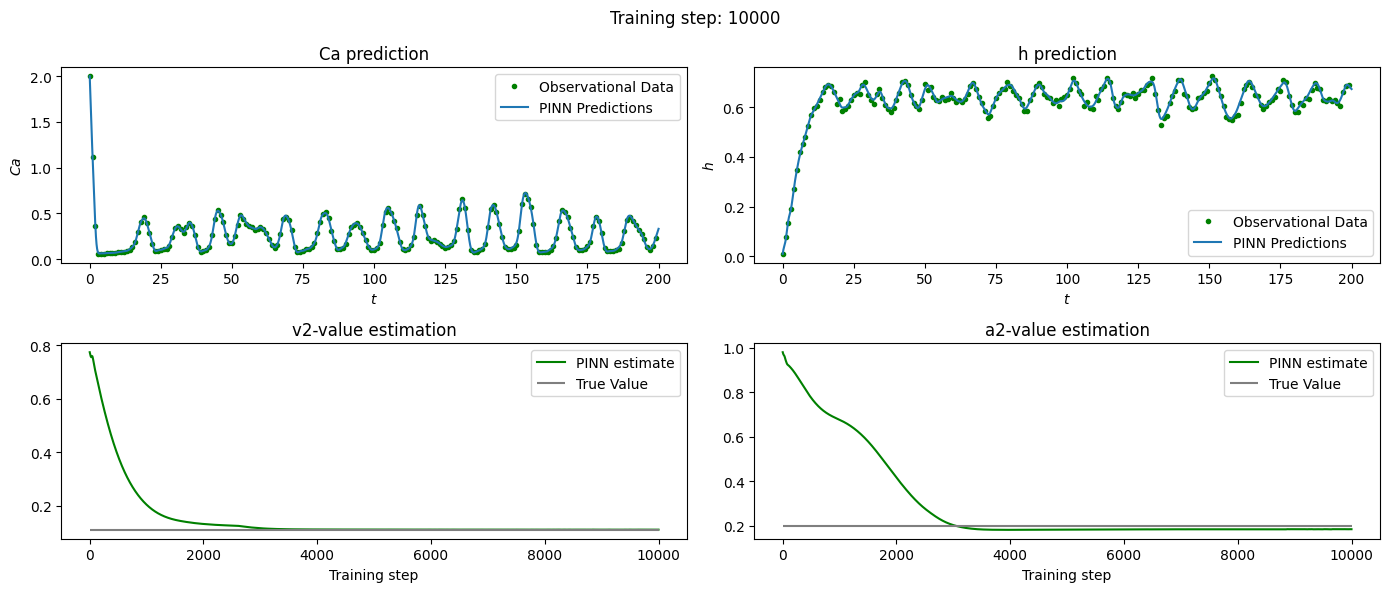

In [124]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.0823
k3  = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.11
#a2 = 0.2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

phy_loss = []
data_loss = []
total_loss = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - y02[0])**2
    loss4 = (torch.squeeze(h0) - y02[1])**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
       phy_loss.append(loss5 + loss6)
       data_loss.append(loss1 + loss2)
       total_loss.append(loss1+ loss2 + loss5 + loss6)

    if i % 1000 == 0:
        print(f"Epoch = {i} | Loss = {loss} | Physics_loss = {loss5 + loss6} | Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.11, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.2, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [125]:
v2s[-1], a2s[-1]

(0.11064348369836807, 0.18457740545272827)

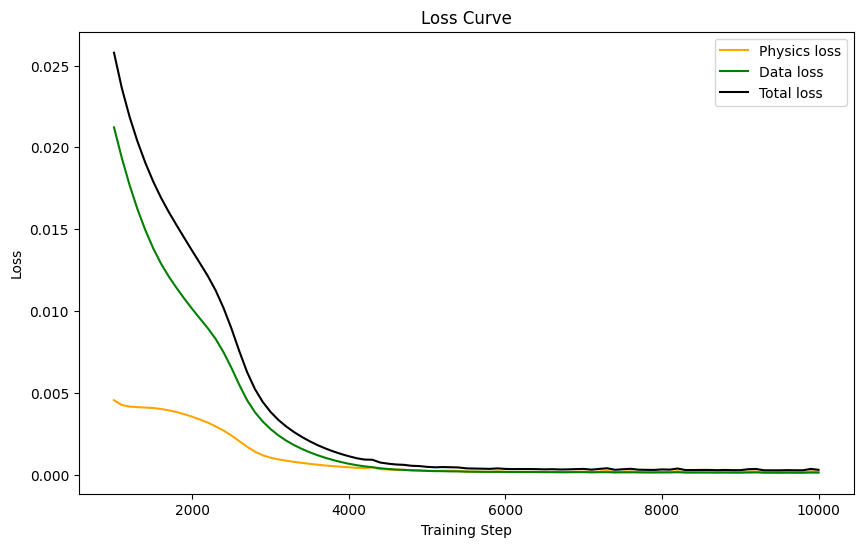

In [134]:
steps = np.linspace(0, 10000, 101)

plt.figure(figsize=(10, 6))
plt.plot(steps[10:], torch.tensor(phy_loss)[10:].detach().numpy(), label="Physics loss", c="orange")
plt.plot(steps[10:], torch.tensor(data_loss)[10:].detach().numpy(), label="Data loss", c="green")
plt.plot(steps[10:], torch.tensor(total_loss)[10:].detach().numpy(), label="Total loss", c="Black")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# **Non Trainable Fourier Coefficients**

In [140]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 1.0
        size = (num_features, 1)
        self.sine_coeff = torch.normal(mean, std, size=size)   
        self.cosine_coeff = torch.normal(mean, std, size=size)

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

## **Stochasric Data - 1**

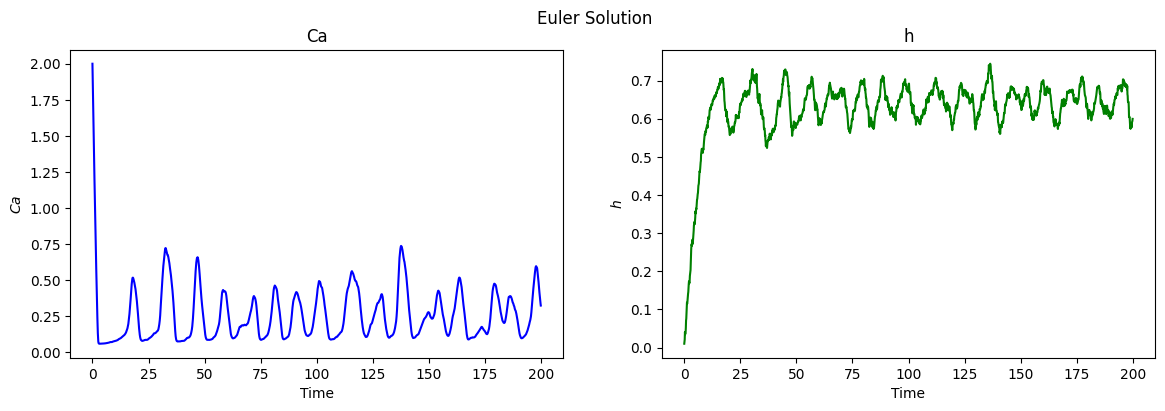

In [135]:
np.random.seed(42)
P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([2.0, 0.01])
y = np.zeros((2, num_steps))
y[:, 0] = y02

for n in range(num_steps - 1):
    f = model_stochastic(t[n], y[:, n], P, dt)
    y[:, n + 1] = y[:, n] + dt * f

Ca_non_stoch, h_non_stoch = y

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_non_stoch, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_non_stoch, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Epoch = 0 | Loss = 0.05347849801182747 | Physics_loss = 1.6836248636245728 | Initial_loss = 0.0 | Data_loss = 3.664224863052368


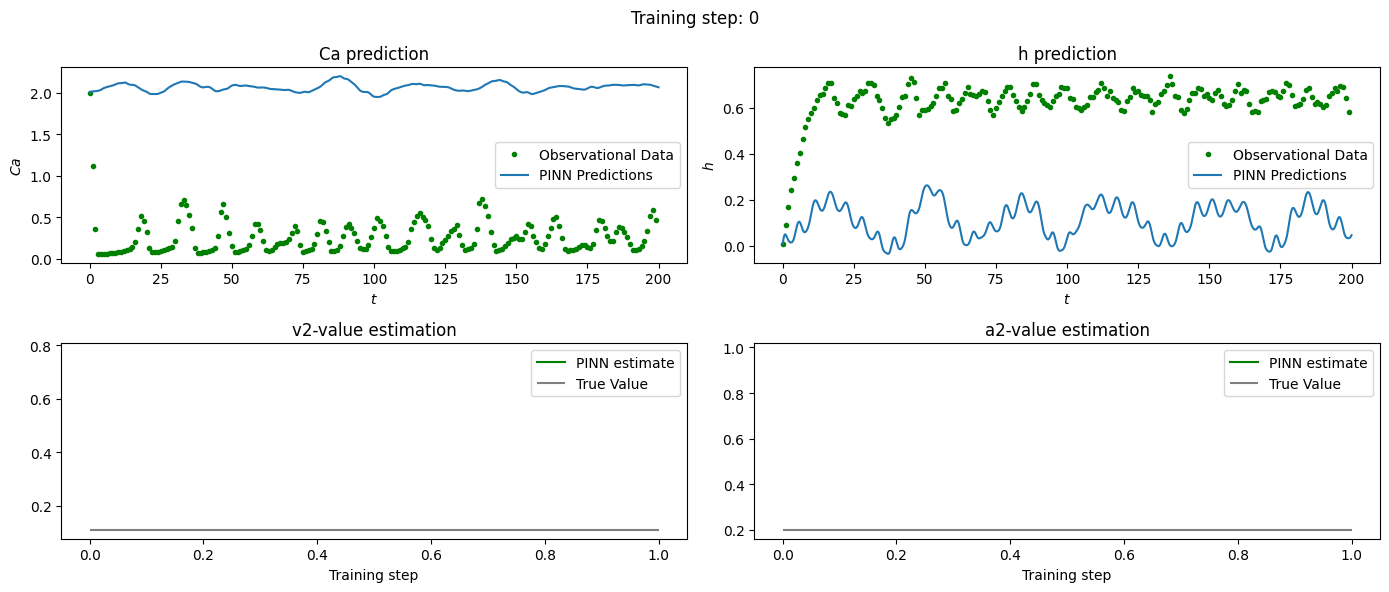

Epoch = 1000 | Loss = 0.00027681971550919116 | Physics_loss = 0.005892875604331493 | Initial_loss = 0.0 | Data_loss = 0.021789096295833588


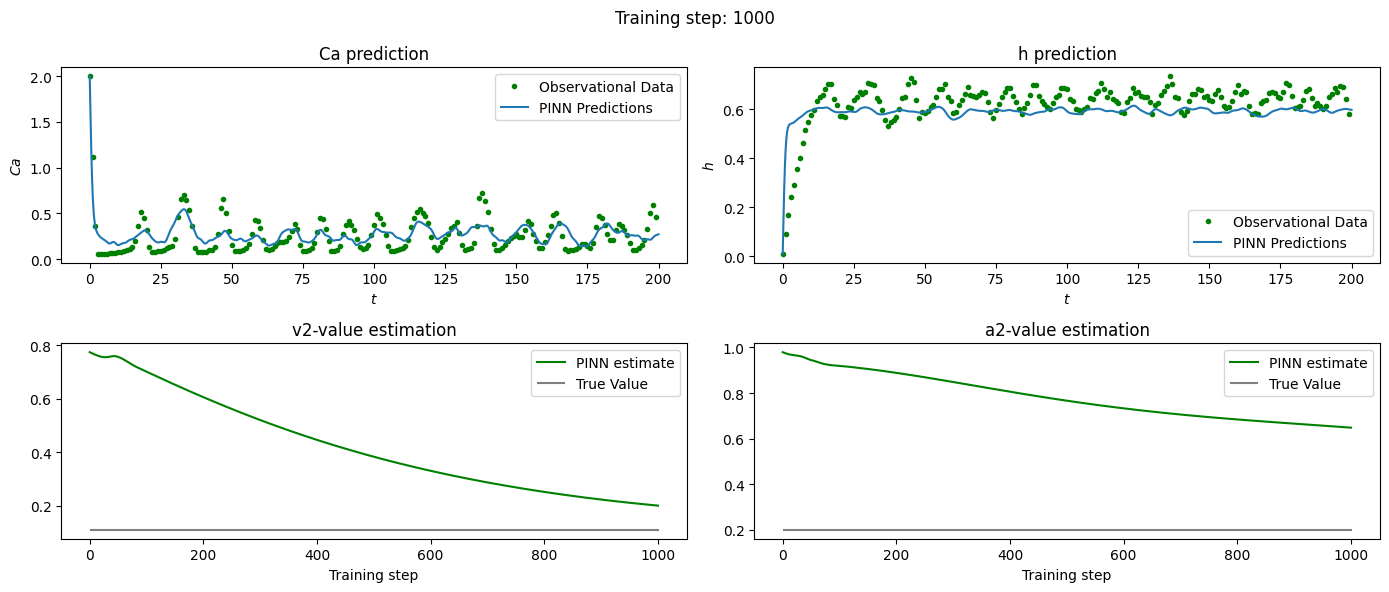

Epoch = 2000 | Loss = 0.00015182432252913713 | Physics_loss = 0.004016771912574768 | Initial_loss = 0.0 | Data_loss = 0.011165659874677658


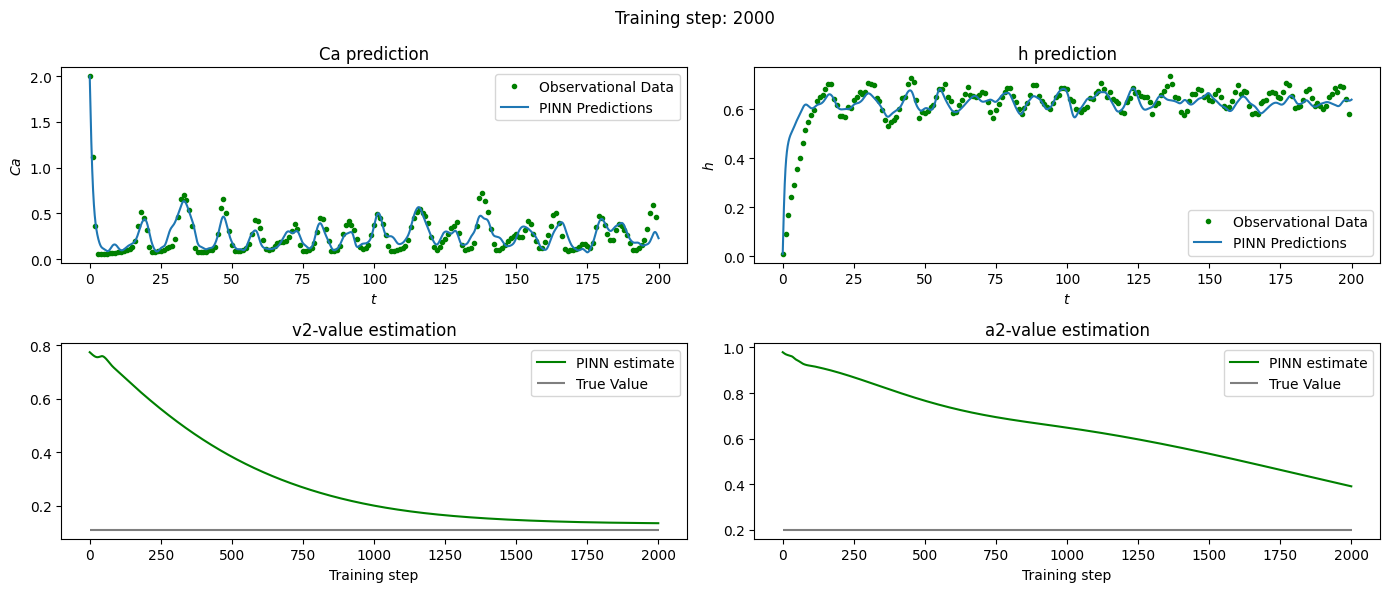

Epoch = 3000 | Loss = 3.234963151044212e-05 | Physics_loss = 0.000932711991481483 | Initial_loss = 0.0 | Data_loss = 0.0023022512905299664


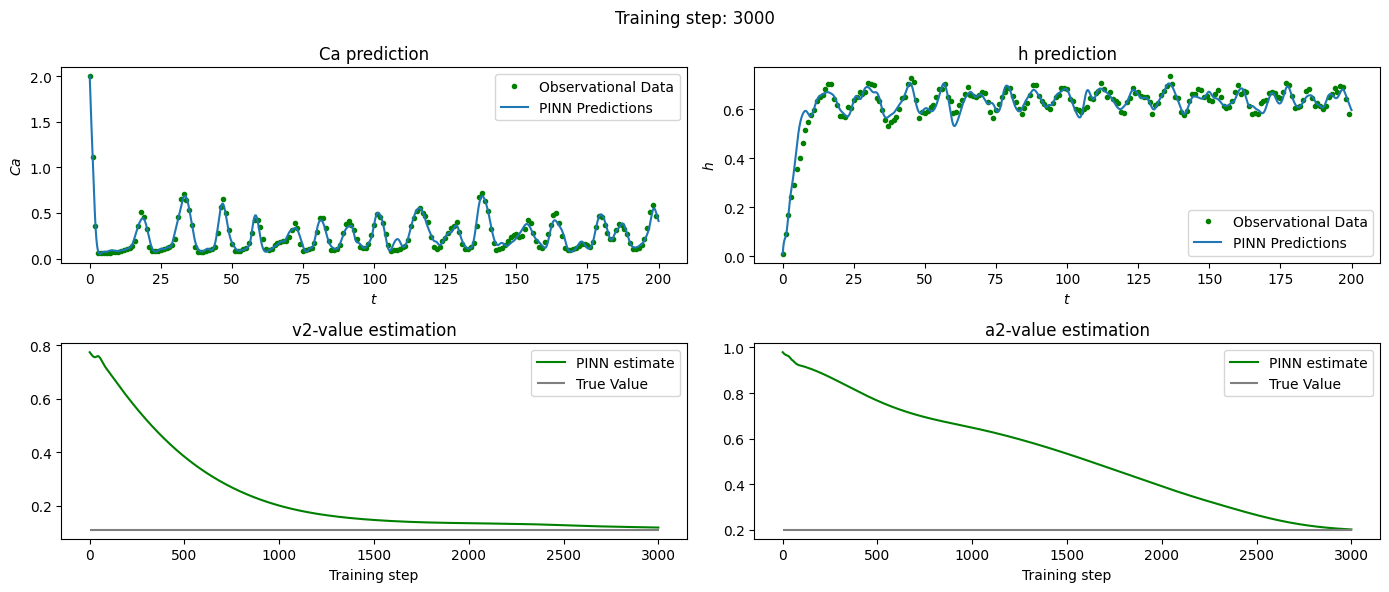

Epoch = 4000 | Loss = 1.4144083252176642e-05 | Physics_loss = 0.0005421534879133105 | Initial_loss = 0.0 | Data_loss = 0.0008722548373043537


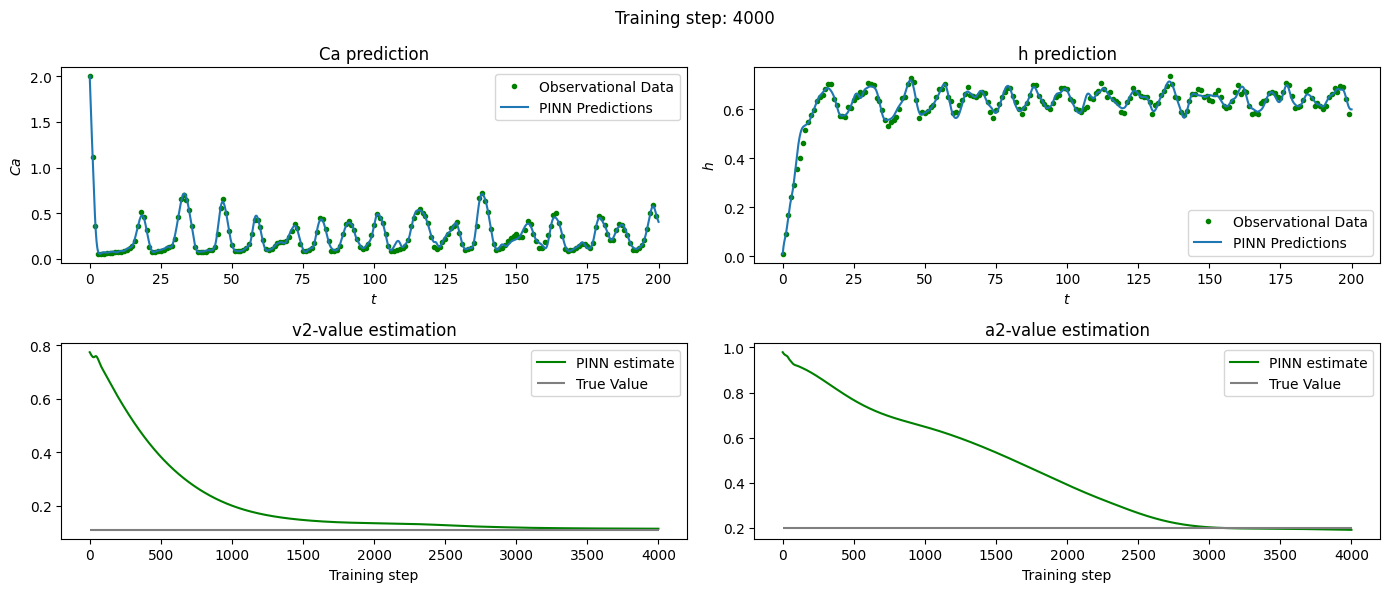

Epoch = 5000 | Loss = 8.425700798397884e-06 | Physics_loss = 0.0003694242041092366 | Initial_loss = 0.0 | Data_loss = 0.00047314591938629746


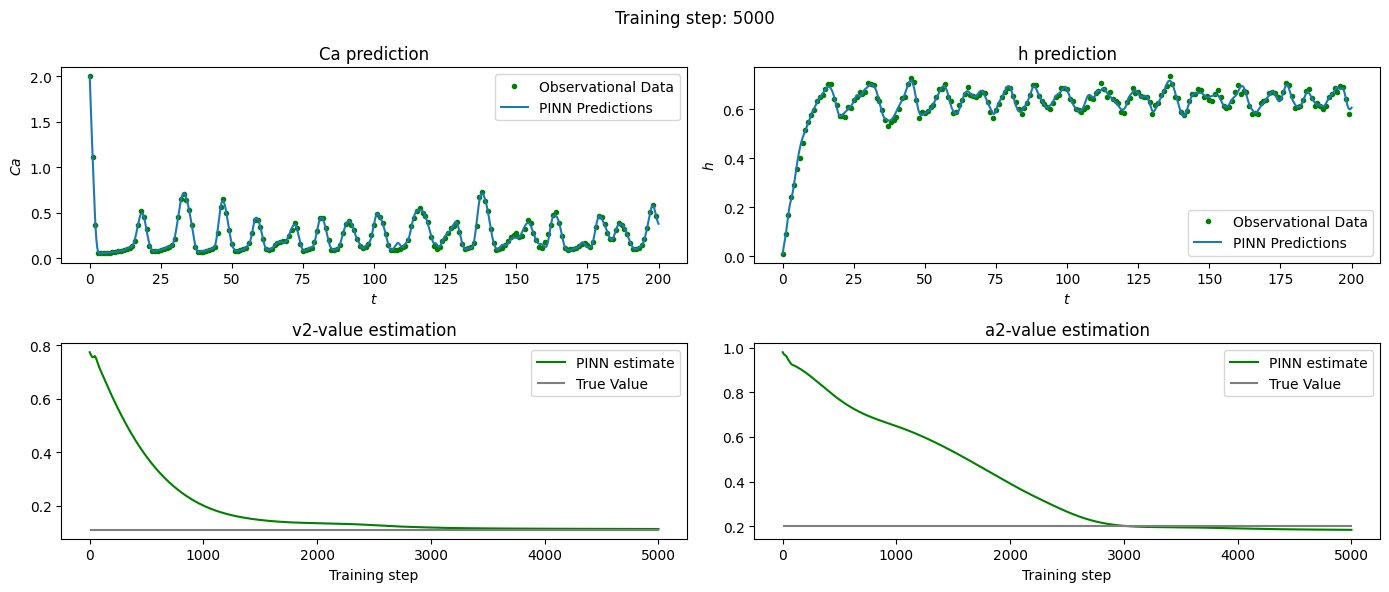

Epoch = 6000 | Loss = 6.554090759891551e-06 | Physics_loss = 0.00031906942604109645 | Initial_loss = 0.0 | Data_loss = 0.00033633969724178314


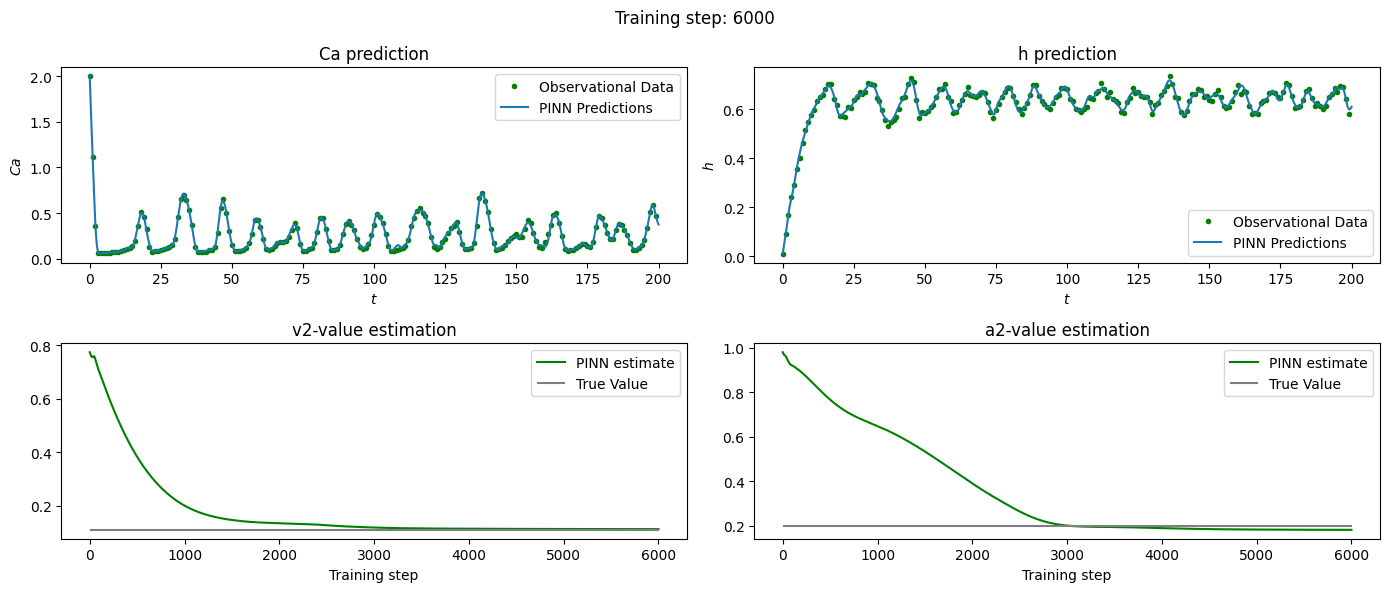

Epoch = 7000 | Loss = 5.881654033146333e-06 | Physics_loss = 0.0003116282168775797 | Initial_loss = 0.0 | Data_loss = 0.0002765371755231172


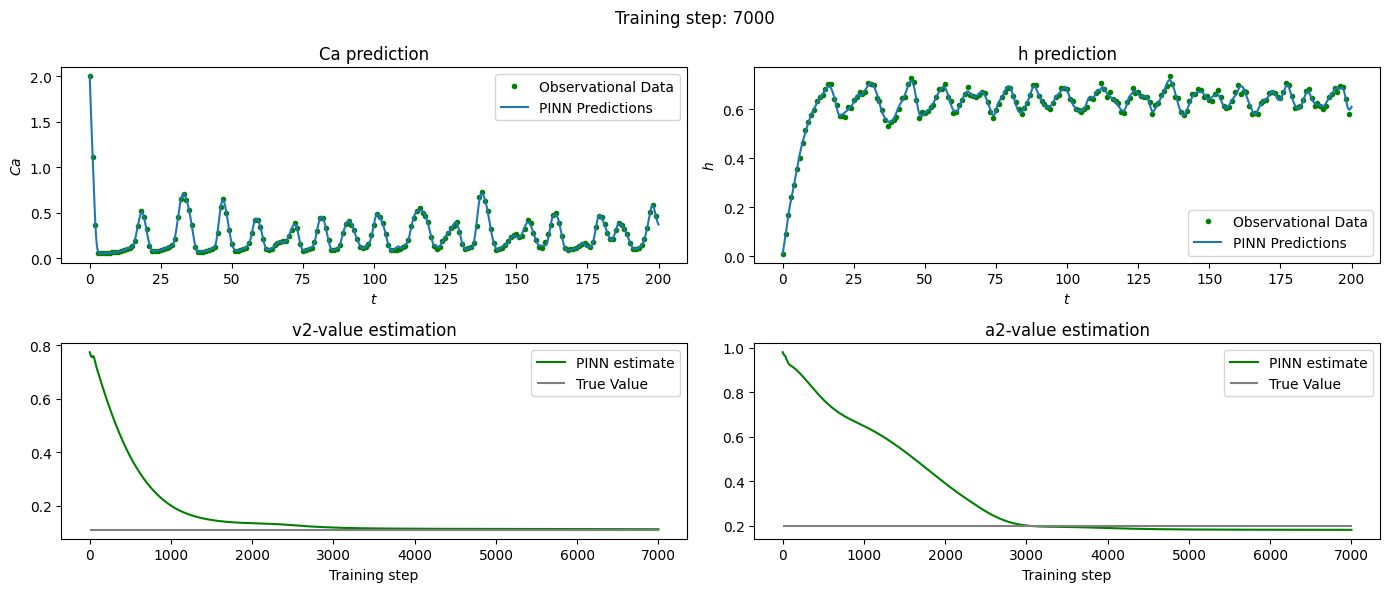

Epoch = 8000 | Loss = 5.02124476042809e-06 | Physics_loss = 0.0002772695152089 | Initial_loss = 0.0 | Data_loss = 0.00022485500085167587


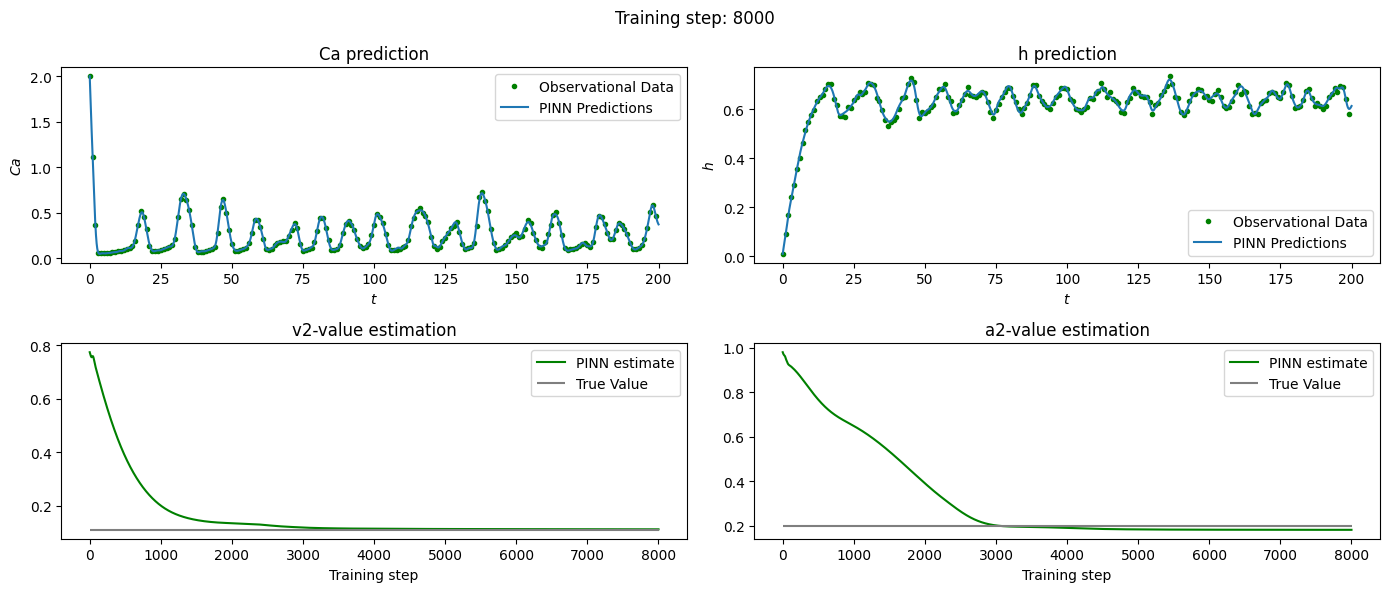

Epoch = 9000 | Loss = 5.070649422123097e-06 | Physics_loss = 0.00029996305238455534 | Initial_loss = 0.0 | Data_loss = 0.00020710192620754242


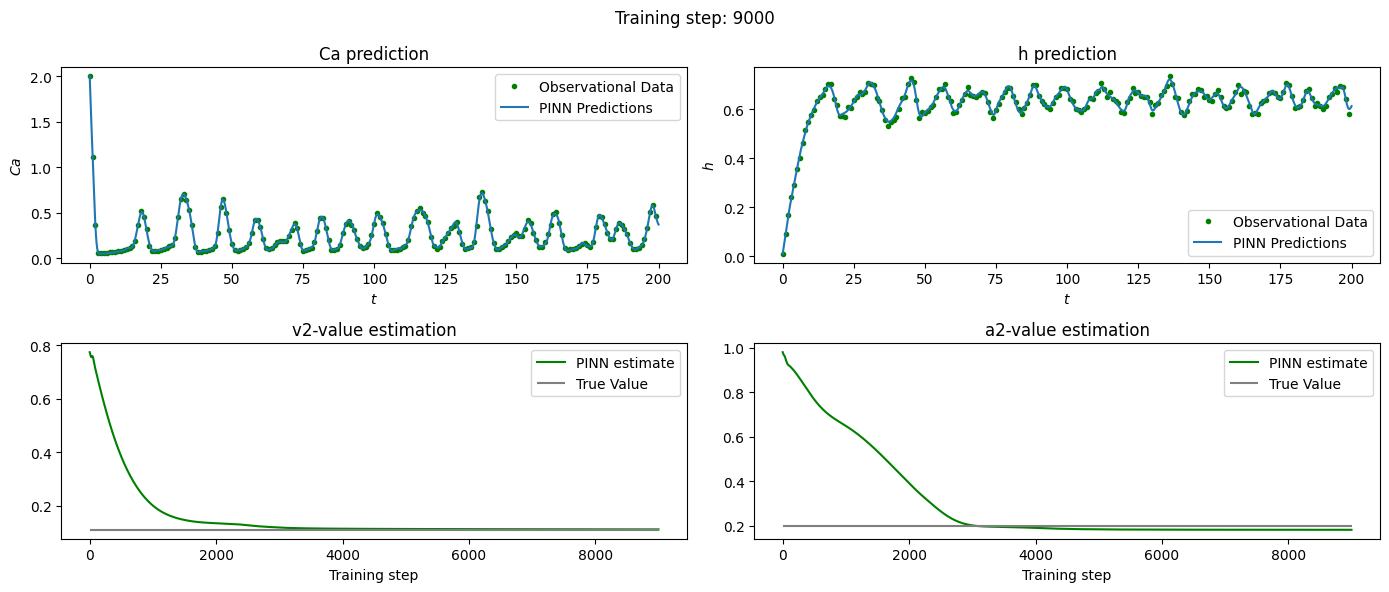

Epoch = 10000 | Loss = 4.325052032072563e-06 | Physics_loss = 0.00025409256340935826 | Initial_loss = 0.0 | Data_loss = 0.00017841262160800397


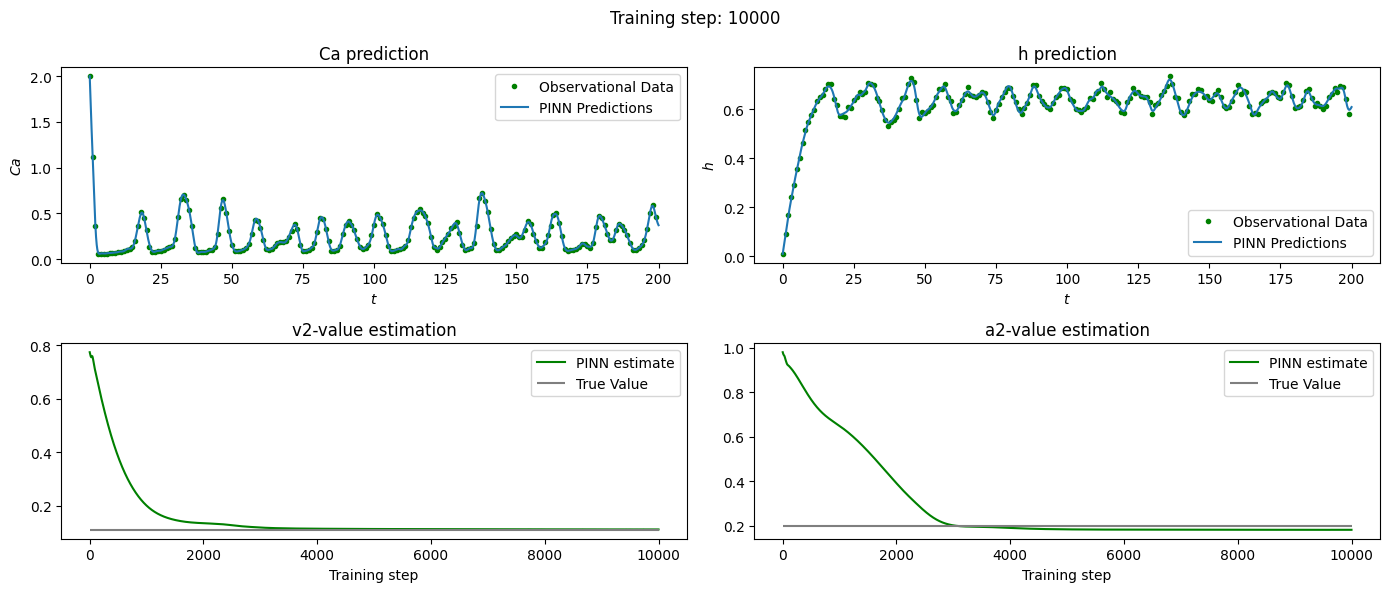

In [136]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.0823
k3  = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.11
#a2 = 0.2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

phy_loss = []
data_loss = []
total_loss = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - y02[0])**2
    loss4 = (torch.squeeze(h0) - y02[1])**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
       phy_loss.append(loss5 + loss6)
       data_loss.append(loss1 + loss2)
       total_loss.append(loss1+ loss2 + loss5 + loss6)

    if i % 1000 == 0:
        print(f"Epoch = {i} | Loss = {loss} | Physics_loss = {loss5 + loss6} | Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.11, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.2, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [137]:
v2s[-1], a2s[-1]

(0.11147405952215195, 0.18196280300617218)

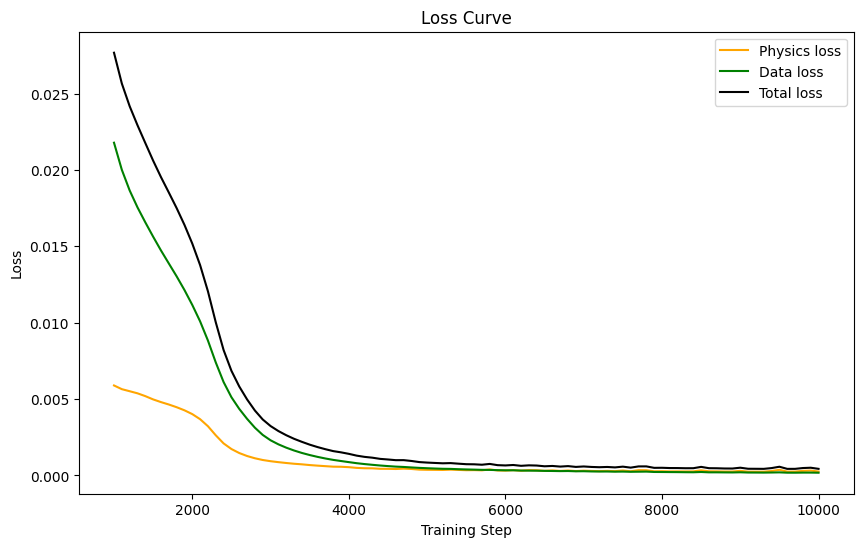

In [138]:
steps = np.linspace(0, 10000, 101)

plt.figure(figsize=(10, 6))
plt.plot(steps[10:], torch.tensor(phy_loss)[10:].detach().numpy(), label="Physics loss", c="orange")
plt.plot(steps[10:], torch.tensor(data_loss)[10:].detach().numpy(), label="Data loss", c="green")
plt.plot(steps[10:], torch.tensor(total_loss)[10:].detach().numpy(), label="Total loss", c="Black")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## **Stochastic Data - 2**

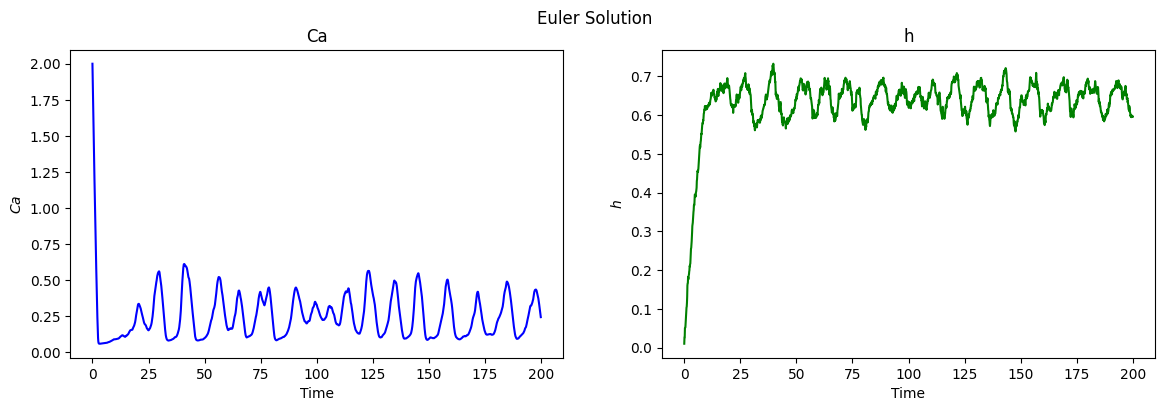

In [139]:
np.random.seed(100)
P = [0.5, 6, 0.11, 0.9, 0.2, 0.13, 1.049, 0.9434, 0.0823, 0.1]
dt = 0.1
t_end = 200
t = np.arange(0, t_end, dt)
num_steps = len(t)
y02 = np.array([2.0, 0.01])
y = np.zeros((2, num_steps))
y[:, 0] = y02

for n in range(num_steps - 1):
    f = model_stochastic(t[n], y[:, n], P, dt)
    y[:, n + 1] = y[:, n] + dt * f

Ca_non_stoch, h_non_stoch = y

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t, Ca_non_stoch, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t, h_non_stoch, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

Epoch = 0 | Loss = 0.0535767525434494 | Physics_loss = 1.6836248636245728 | Initial_loss = 0.0 | Data_loss = 3.6740505695343018


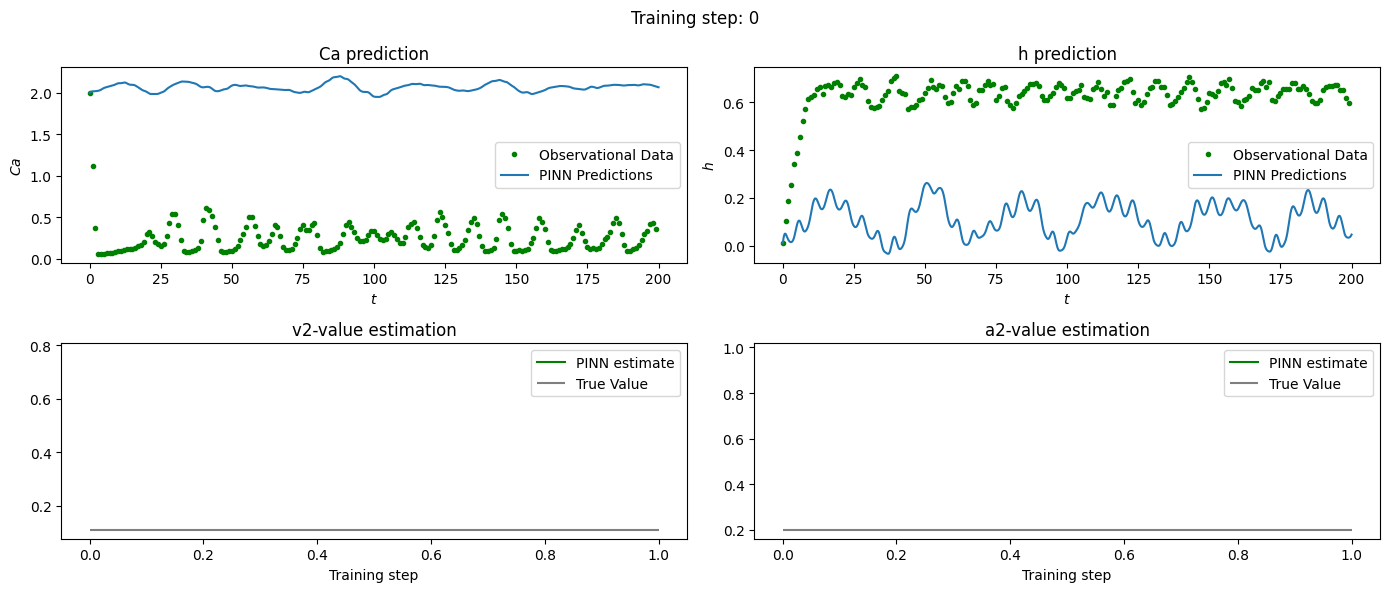

Epoch = 1000 | Loss = 0.0002578166895546019 | Physics_loss = 0.00455900002270937 | Initial_loss = 0.0 | Data_loss = 0.021222667768597603


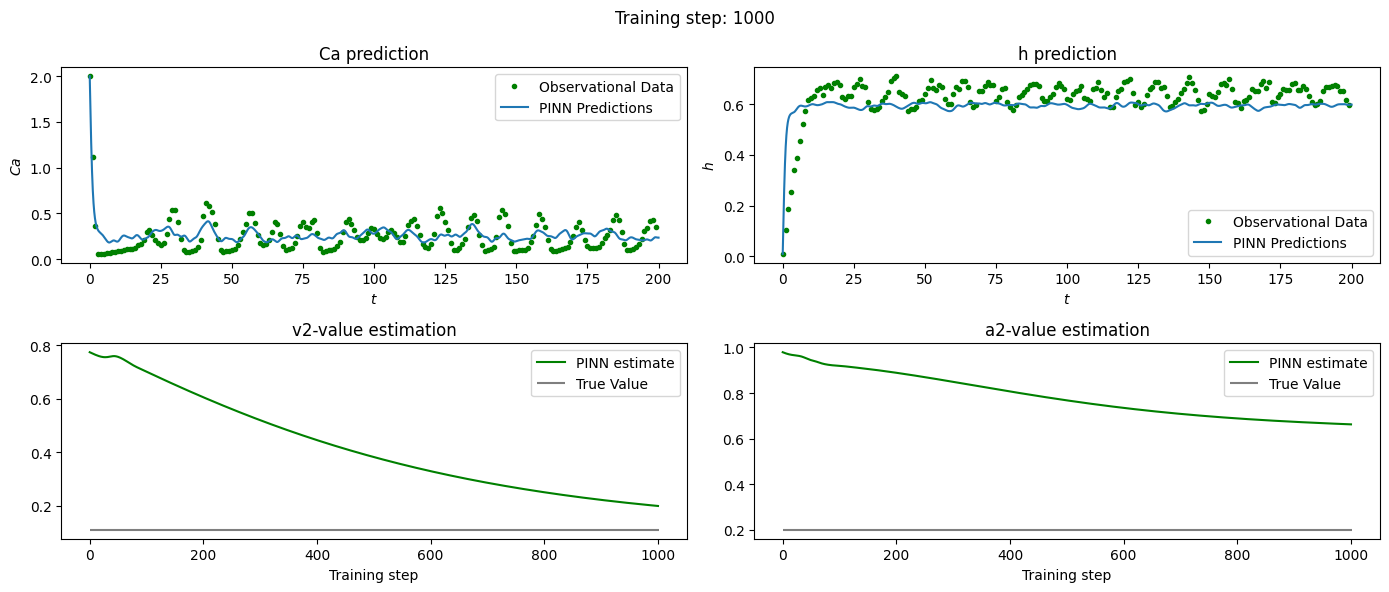

Epoch = 2000 | Loss = 0.00013673592184204608 | Physics_loss = 0.003547139000147581 | Initial_loss = 0.0 | Data_loss = 0.010126453824341297


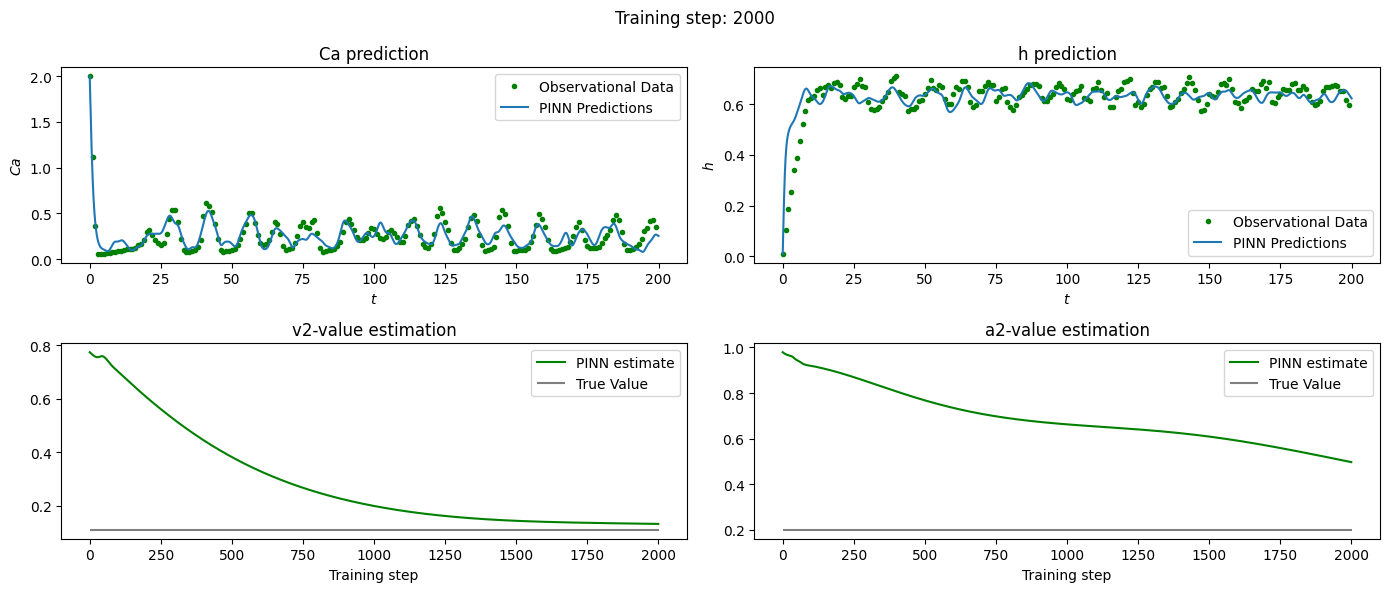

Epoch = 3000 | Loss = 3.842673322651535e-05 | Physics_loss = 0.001047797384671867 | Initial_loss = 0.0 | Data_loss = 0.0027948757633566856


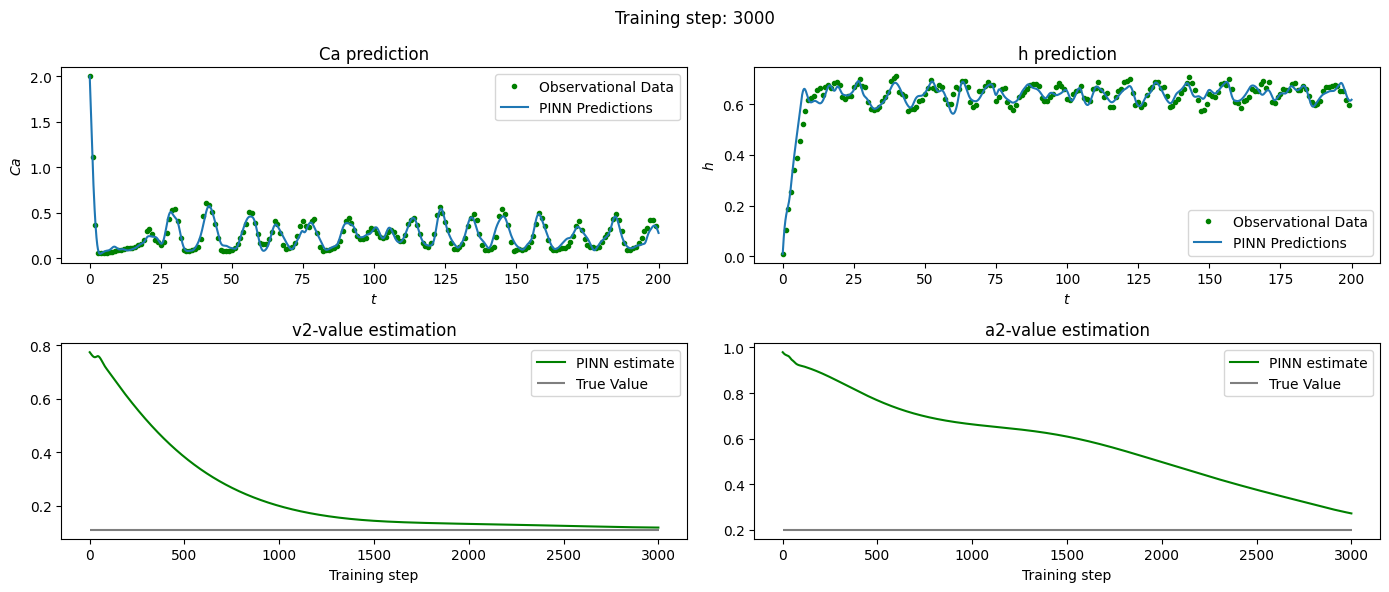

Epoch = 4000 | Loss = 1.1364074453013018e-05 | Physics_loss = 0.00045915789087302983 | Initial_loss = 0.0 | Data_loss = 0.0006772495689801872


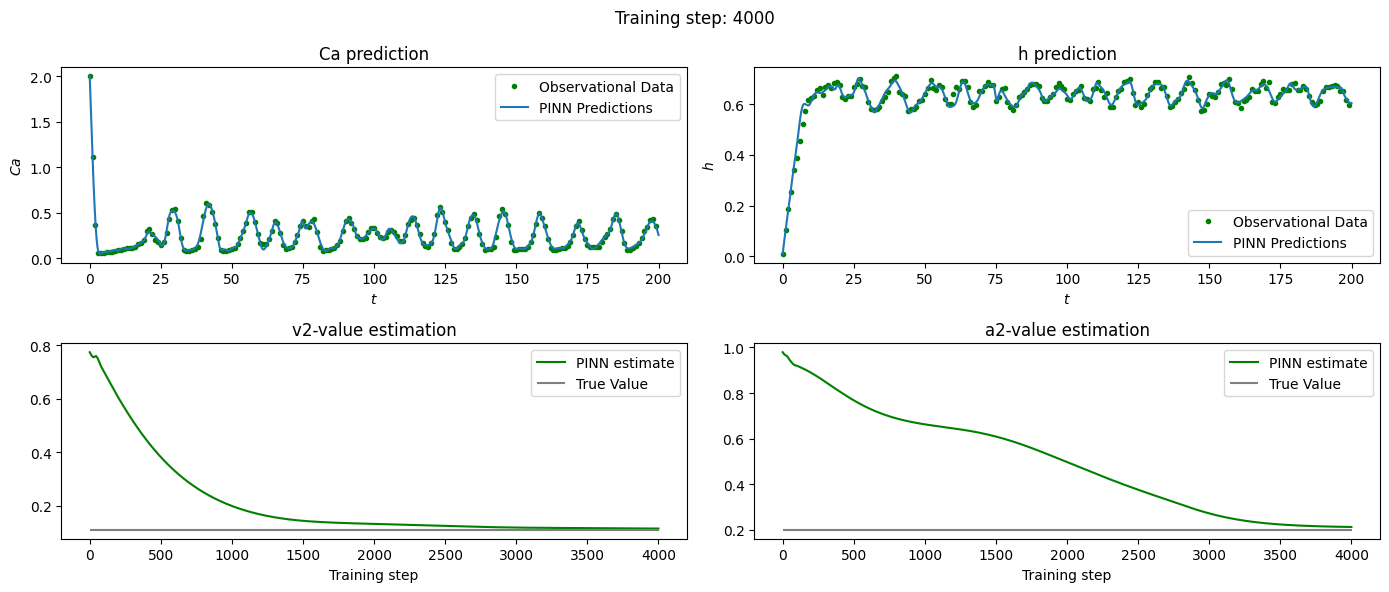

Epoch = 5000 | Loss = 4.874623300565872e-06 | Physics_loss = 0.0002480028779245913 | Initial_loss = 0.0 | Data_loss = 0.00023945947759784758


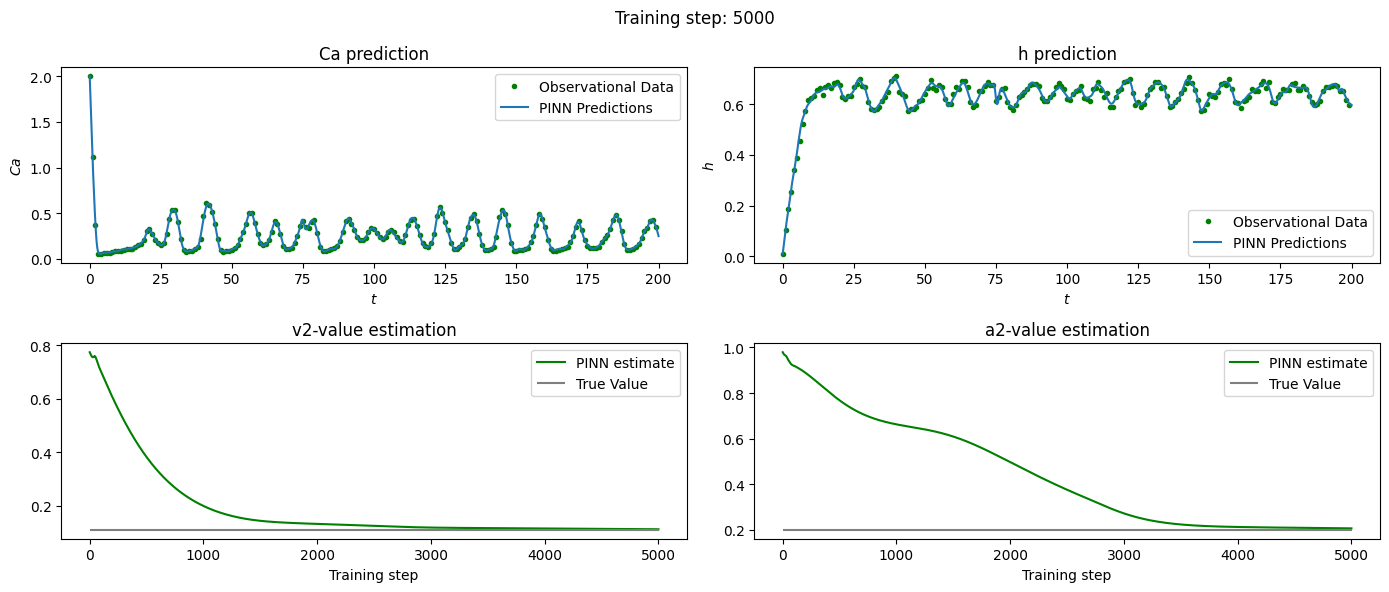

Epoch = 6000 | Loss = 3.6196940982335946e-06 | Physics_loss = 0.0001849905529525131 | Initial_loss = 0.0 | Data_loss = 0.00017697886505629867


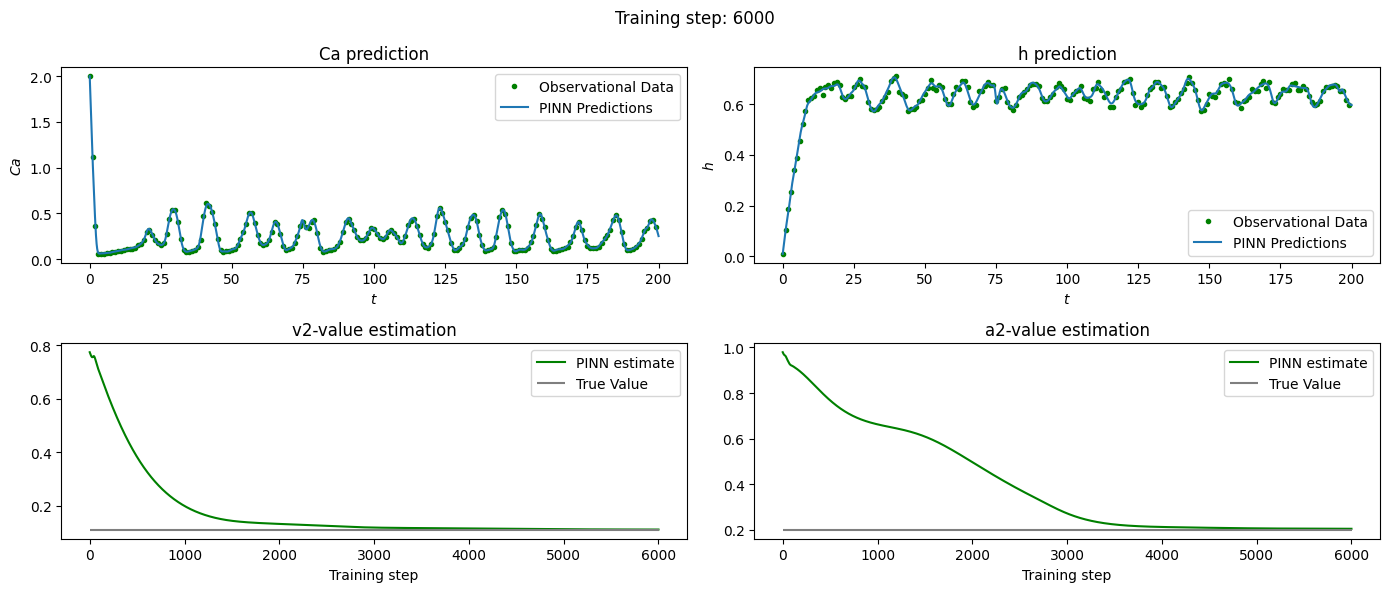

Epoch = 7000 | Loss = 3.6325002383819083e-06 | Physics_loss = 0.00019836632418446243 | Initial_loss = 0.0 | Data_loss = 0.0001648837060201913


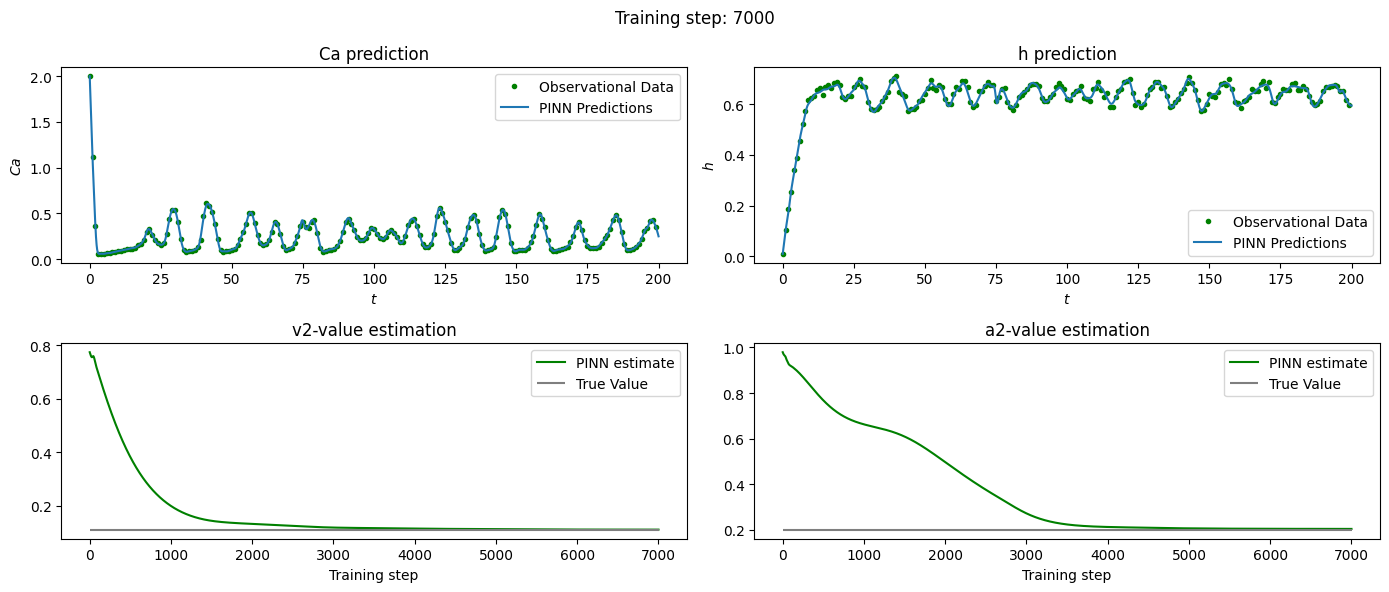

Epoch = 8000 | Loss = 3.3168539630423766e-06 | Physics_loss = 0.00018606323283165693 | Initial_loss = 0.0 | Data_loss = 0.00014562217984348536


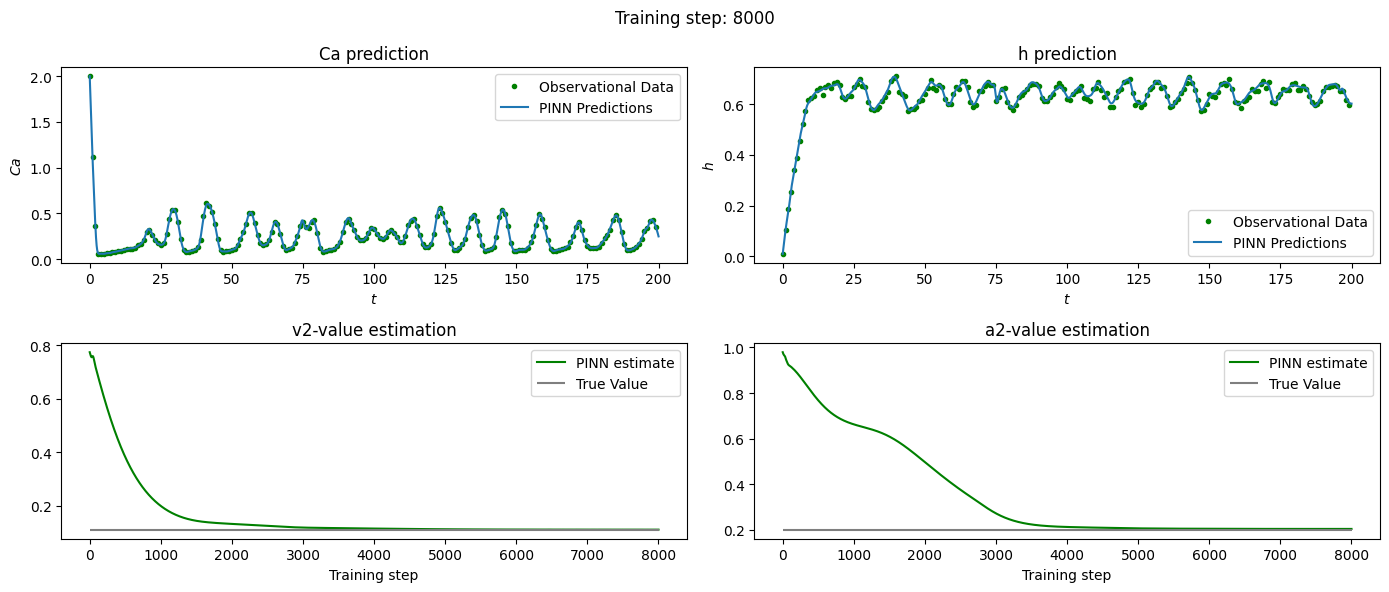

Epoch = 9000 | Loss = 2.8592974103958113e-06 | Physics_loss = 0.0001497476187068969 | Initial_loss = 0.0 | Data_loss = 0.00013618211960420012


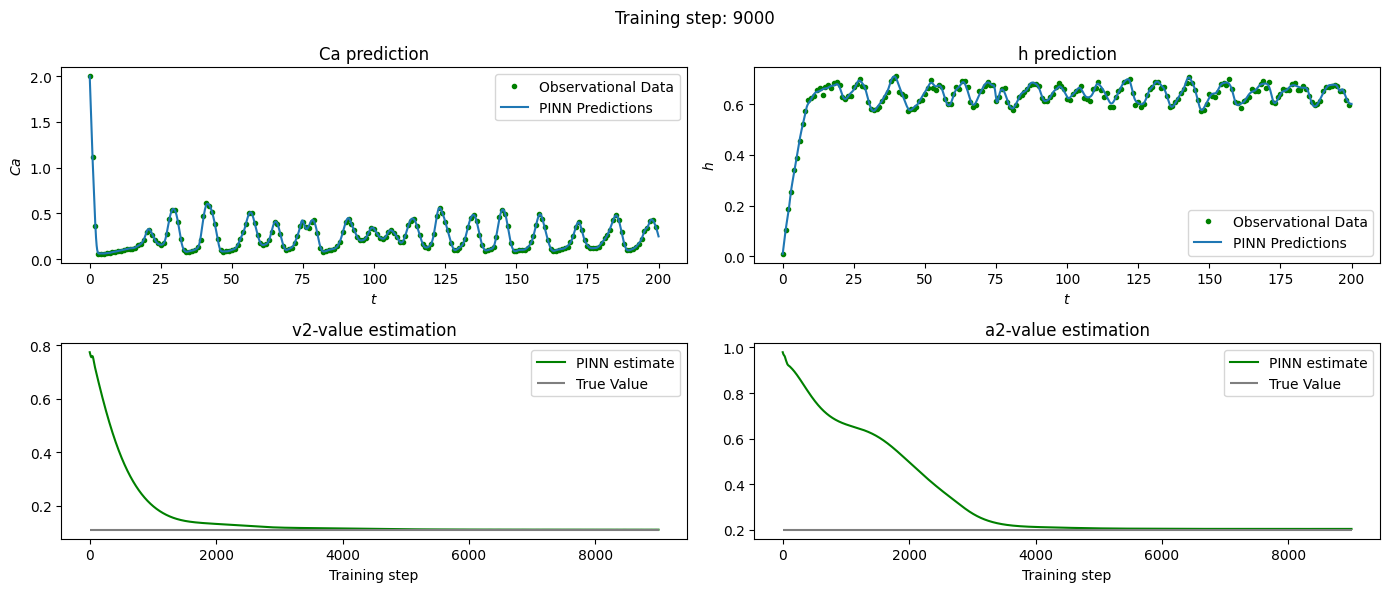

Epoch = 10000 | Loss = 3.0648279789602384e-06 | Physics_loss = 0.00016980808868538588 | Initial_loss = 0.0 | Data_loss = 0.0001366747310385108


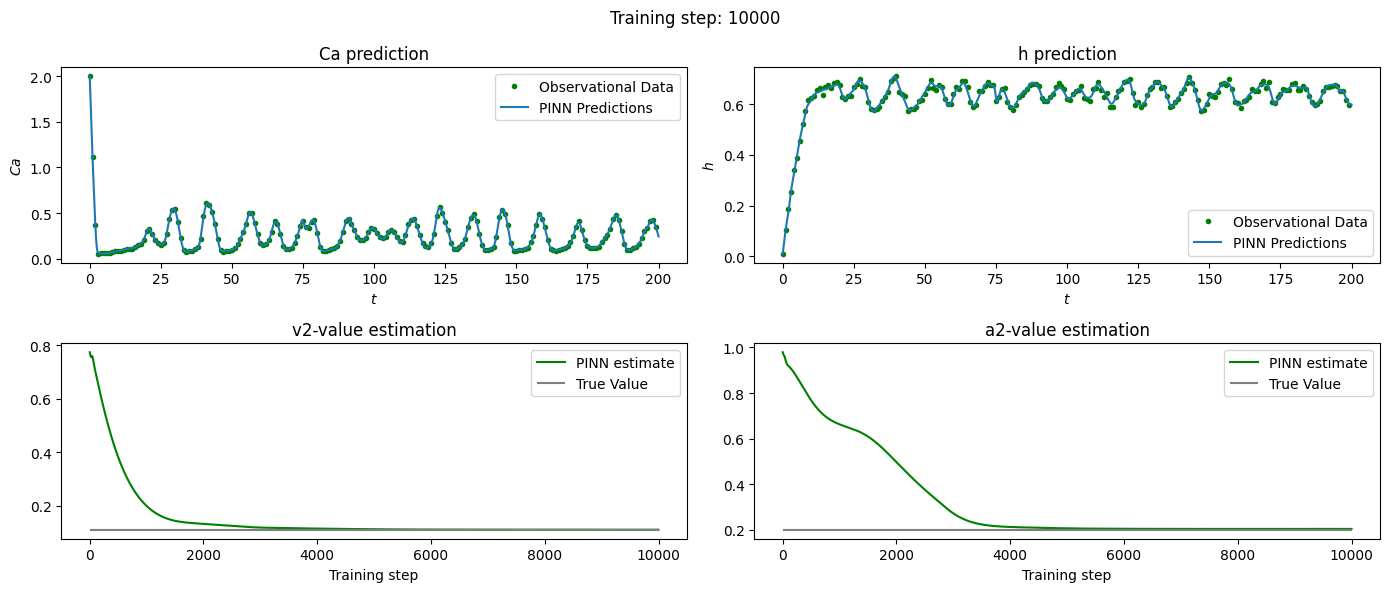

In [141]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.0823
k3  = 0.1
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.11
#a2 = 0.2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

phy_loss = []
data_loss = []
total_loss = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - y02[0])**2
    loss4 = (torch.squeeze(h0) - y02[1])**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 100 == 0:
       phy_loss.append(loss5 + loss6)
       data_loss.append(loss1 + loss2)
       total_loss.append(loss1+ loss2 + loss5 + loss6)

    if i % 1000 == 0:
        print(f"Epoch = {i} | Loss = {loss} | Physics_loss = {loss5 + loss6} | Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(0.11, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(0.2, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()


In [142]:
v2s[-1], a2s[-1]

(0.1104607880115509, 0.20401631295681)

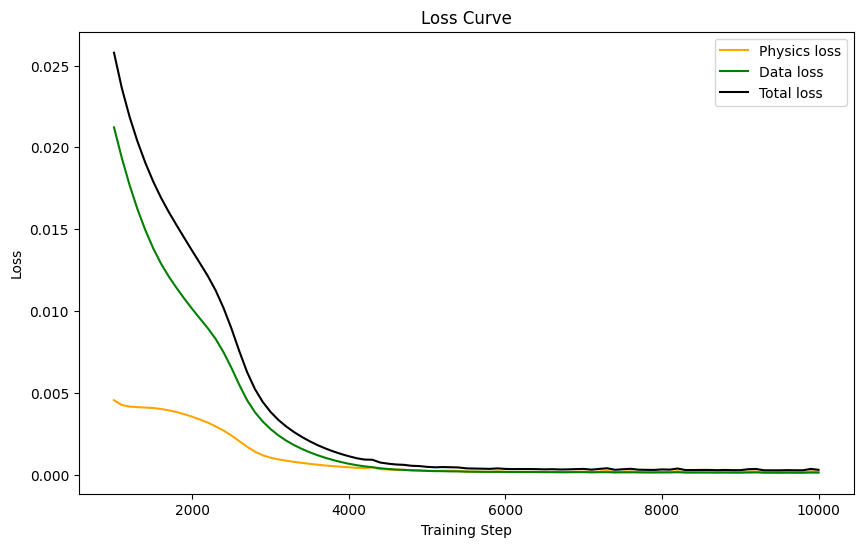

In [143]:
steps = np.linspace(0, 10000, 101)

plt.figure(figsize=(10, 6))
plt.plot(steps[10:], torch.tensor(phy_loss)[10:].detach().numpy(), label="Physics loss", c="orange")
plt.plot(steps[10:], torch.tensor(data_loss)[10:].detach().numpy(), label="Data loss", c="green")
plt.plot(steps[10:], torch.tensor(total_loss)[10:].detach().numpy(), label="Total loss", c="Black")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# **Multi Parameter Estimation**

In [ ]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor(y02, dtype=torch.float).view(1,-1))

Ca_euler = torch.tensor(Ca_non_stoch, dtype=torch.float32)[::10]
h_euler = torch.tensor(h_non_stoch, dtype=torch.float32)[::10]
t_test = torch.arange(0, t_end, 0.01).view(-1, 1)
time = torch.arange(0, t_end, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, t_end, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1_t, v3_t = 6, 0.9
d1_t, d2_t, d3_t, Nd = 0.13, 1.049, 0.9434, 2
IP3_t = 0.5
d5_t = 0.0823
k3_t  = 0.1
v2_t = 0.11
a2_t = 0.2

IP3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
v1 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
v3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d1 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d5 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [IP3, v1, v2, v3, a2, d1, d2, d3, d5, k3], lr=0.001)
epochs =  10001

IP3s = []
v1s = []
v2s = []
v3s = []
a2s = []
d1s = []
d2s = []
d3s = []
d5s = []
k3s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    IP3s.append(IP3.item())
    v1s.append(v1.item())
    v2s.append(v2.item())
    v3s.append(v3.item())
    a2s.append(a2.item())
    d1s.append(d1.item())
    d2s.append(d2.item())
    d3s.append(d3.item())
    d5s.append(d5.item())
    k3s.append(k3.item())


    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 4))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(121)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions")
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(122)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions")
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(14, 10))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(5,2,1)
        plt.plot(IP3s, label="PINN estimate", c='green')
        plt.hlines(IP3_t, 0, len(IP3s), color="tab:grey", label="True Value")
        plt.title("IP3-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,2)
        plt.plot(v1s, label="PINN estimate", c='green')
        plt.hlines(v1_t, 0, len(v1s), color="tab:grey", label="True Value")
        plt.title("v1-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,3)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(v2_t, 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,4)
        plt.plot(v3s, label="PINN estimate", c='green')
        plt.hlines(v3_t, 0, len(v3s), color="tab:grey", label="True Value")
        plt.title("v3-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,5)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(a2_t, 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,6)
        plt.plot(d1s, label="PINN estimate", c='green')
        plt.hlines(d1_t, 0, len(d1s), color="tab:grey", label="True Value")
        plt.title("d1-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,7)
        plt.plot(d2s, label="PINN estimate", c='green')
        plt.hlines(d2_t, 0, len(d2s), color="tab:grey", label="True Value")
        plt.title("d2-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,8)
        plt.plot(d3s, label="PINN estimate", c='green')
        plt.hlines(d3_t, 0, len(d3s), color="tab:grey", label="True Value")
        plt.title("d3-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,9)
        plt.plot(d5s, label="PINN estimate", c='green')
        plt.hlines(d5_t, 0, len(d5s), color="tab:grey", label="True Value")
        plt.title("d5-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.subplot(5,2,10)
        plt.plot(k3s, label="PINN estimate", c='green')
        plt.hlines(k3_t, 0, len(k3s), color="tab:grey", label="True Value")
        plt.title("k3-value estimation")
        plt.xlabel("Training step")
        plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()
